<a href="https://colab.research.google.com/github/64FC/OC_P7/blob/main/P7_01_analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Préparation de l'environnement Google Colab

A modifier en amont (Colab Pro):
* Exécution > Modifier le type d'exécution
* Sélectionner "Mémoire RAM élevée"

A importer en amont:
* Le dossier zippé contenant les données CSV, en version light (3 minutes environ)

In [ ]:
# Vérification de la RAM disponible (code from Google)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
# Dézipper le fichier
# Ce fichier zippé, ne contient que application_test et application_train
# car trop lourd à charger sinon
!unzip Projet-home-credit-light-data.zip

Archive:  Projet-home-credit-light-data.zip
  inflating: Projet-home-credit-light-data/application_test.csv  
  inflating: Projet-home-credit-light-data/application_train.csv  


# Import des données

In [ ]:
# Import des librairies
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno # Pour les valeurs manquantes

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [ ]:
np.__version__

'1.19.5'

In [ ]:
import sklearn
sklearn.__version__

'1.0.1'

## Connexion aux sources de données

In [ ]:
# Données d'entraînement
app_train = pd.read_csv('Projet-home-credit-light-data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET  ... AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_YEAR
0      100002       1  ...                       0.0                        1.0
1      100003       0  ...                       0.0                        0.0
2      100004       0  ...                       0.0                        0.0
3      100006       0  ...                       NaN                        NaN
4      100007       0  ...                       0.0                        0.0

[5 rows x 122 columns]

In [ ]:
# Données de test
app_test = pd.read_csv('Projet-home-credit-light-data/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


SK_ID_CURR  ... AMT_REQ_CREDIT_BUREAU_YEAR
0      100001  ...                        0.0
1      100005  ...                        3.0
2      100013  ...                        4.0
3      100028  ...                        3.0
4      100038  ...                        NaN

[5 rows x 121 columns]

## Préparation des données (sampling)

In [ ]:
# Le jeu de données d'entrainement étant trop volumineux ici, je n'en conserve que 20%
app_train_20 = app_train.sample(frac=.2, random_state=23)

In [ ]:
# Je réindexe ensuite
app_train_20 = app_train_20.reset_index(drop=True)

In [ ]:
##### SAMPLING POUR LA PoC (3%) #####
train_poc = app_train.sample(frac=.03, random_state=23)
test_poc = app_test.sample(frac=.03, random_state=23)

# Je réindexe ensuite
train_poc = train_poc.reset_index(drop=True)
test_poc = test_poc.reset_index(drop=True)

In [ ]:
# Puis j'exporte mes données
train_poc.to_csv("train_poc.csv", sep='\t', index=False)
test_poc.to_csv("test_poc.csv", sep='\t', index=False)

# Analyse exploratoire

In [ ]:
# Définition du jeu de données à explorer
#train_eda = app_train_20.copy()
#test_eda = app_test.copy()
# Analyse pour la PoC
train_eda = train_poc.copy()
test_eda = test_poc.copy()

## Distribution de la colonne cible:
- 0: le prêt est rendu à temps
- 1: le client a des difficultés de paiement

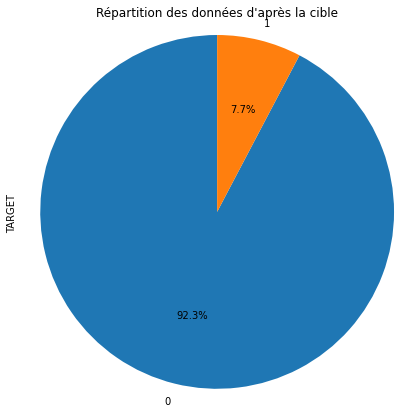

In [ ]:
# Je regarde la répartition des données d'après la cible
train_eda['TARGET'].value_counts(normalize=True).plot(kind='pie', startangle=90, autopct='%1.1f%%', figsize=(7,7), title="Répartition des données d'après la cible")
# normalize = True permet d'obtenir les fréquences
# startangle = 90 permet de commencer à 90°, la rotation s'effectue ensuite en sens inverse des aiguilles
# autopct = '%1.1f%%' permet d'ajouter les pourcentages formatés au 10e. Pour les avoir au centième, '%1.2f%%' etc
# figsize = (6,6) permet de redimensionner la figure
plt.axis('equal') 
plt.show()

On remarque ici un problème de distribution (class-imbalance). Il y a beaucoup plus de prêts qui ont été repayés à temps (0) que de prêts non remboursés (1). Nous pourrons par la suite ajuster le poids des classes pour refleter cette distribution.

## Distribution d'après le genre

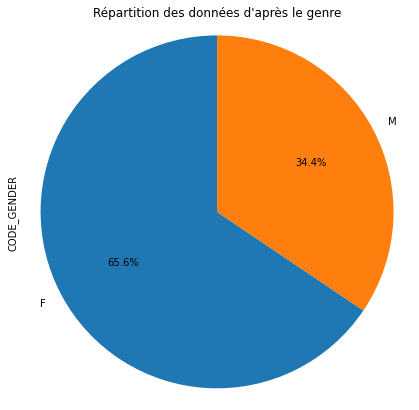

In [ ]:
# Je regarde la répartition des données
train_eda['CODE_GENDER'].value_counts(normalize=True).plot(kind='pie', startangle=90, autopct='%1.1f%%', figsize=(7,7), title="Répartition des données d'après le genre")
# normalize = True permet d'obtenir les fréquences
# startangle = 90 permet de commencer à 90°, la rotation s'effectue ensuite en sens inverse des aiguilles
# autopct = '%1.1f%%' permet d'ajouter les pourcentages formatés au 10e. Pour les avoir au centième, '%1.2f%%' etc
# figsize = (6,6) permet de redimensionner la figure
plt.axis('equal') 
plt.show()

In [ ]:
# On ne considère pas le genre XNA, qui parait aberrant:
train_eda = train_eda[train_eda['CODE_GENDER'] != 'XNA']

# Je réindexe ensuite
train_eda = train_eda.reset_index(drop = True)

## Distribution d'après l'éducation

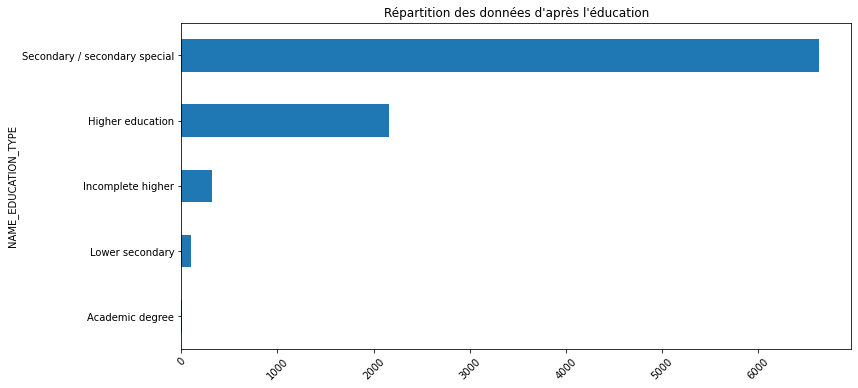

In [ ]:
# Je regarde la répartition des données
fig = plt.figure(figsize=(12, 6))

train_eda.groupby('NAME_EDUCATION_TYPE').size().sort_values(ascending=True).plot.barh(title="Répartition des données d'après l'éducation")
plt.xticks(rotation=45)
plt.show()

## Analyse des valeurs manquantes

In [ ]:
# Fonction pour calculer les valeurs manquantes par colonne
def missing_values_table(df):
        # Valeurs manquantes total
        mis_val = df.isnull().sum()
        
        # Pourcentage de valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Création d'une table de résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # On renomme les colonnes
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Valeurs manquantes', 1 : '% du total'})
        
        # On trie la table par pourcentage de valeurs manquantes DESC
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% du total', ascending=False).round(1)
        
        # On affiche un résumé d'informations
        print ("Le dataframe sélectionné a " + str(df.shape[1]) + " colonnes.\nIl y a " + str(mis_val_table_ren_columns.shape[0]) + " colonnes qui ont des valeurs manquantes.")
        
        # On retourne le tableau des valeurs manquantes
        return mis_val_table_ren_columns

In [ ]:
# On applique sur le jeu de données d'entraînement
missing_values = missing_values_table(train_eda)
# On affiche les 20 colonnes les plus vides
missing_values.head(20)

Le dataframe sélectionné a 122 colonnes.
Il y a 64 colonnes qui ont des valeurs manquantes.


Valeurs manquantes  % du total
COMMONAREA_AVG                          6447        69.9
COMMONAREA_MODE                         6447        69.9
COMMONAREA_MEDI                         6447        69.9
NONLIVINGAPARTMENTS_MODE                6402        69.4
NONLIVINGAPARTMENTS_AVG                 6402        69.4
NONLIVINGAPARTMENTS_MEDI                6402        69.4
FONDKAPREMONT_MODE                      6304        68.3
LIVINGAPARTMENTS_MODE                   6292        68.2
LIVINGAPARTMENTS_MEDI                   6292        68.2
LIVINGAPARTMENTS_AVG                    6292        68.2
FLOORSMIN_MEDI                          6253        67.8
FLOORSMIN_AVG                           6253        67.8
FLOORSMIN_MODE                          6253        67.8
OWN_CAR_AGE                             6147        66.6
YEARS_BUILD_AVG                         6143        66.6
YEARS_BUILD_MEDI                        6143        66.6
YEARS_BUILD_MODE                        6143        66.6
LANDAREA_MEDI                           5535        60.0
LANDAREA_MODE                           5535        60.0
LANDAREA_AVG                            5535        60.0

Il y a beaucoup de valeurs manquantes ici, qu'il faudra traiter.

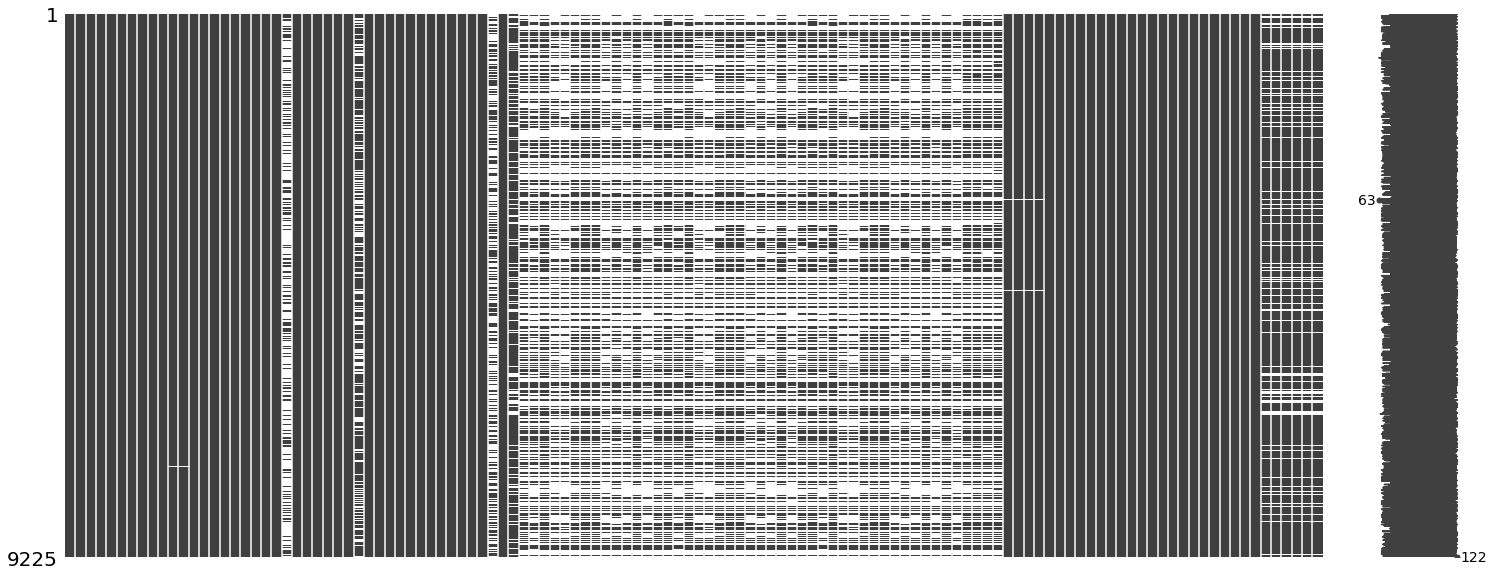

In [ ]:
msno.matrix(train_eda)
# Les lignes blanches indiquent les valeurs manquantes

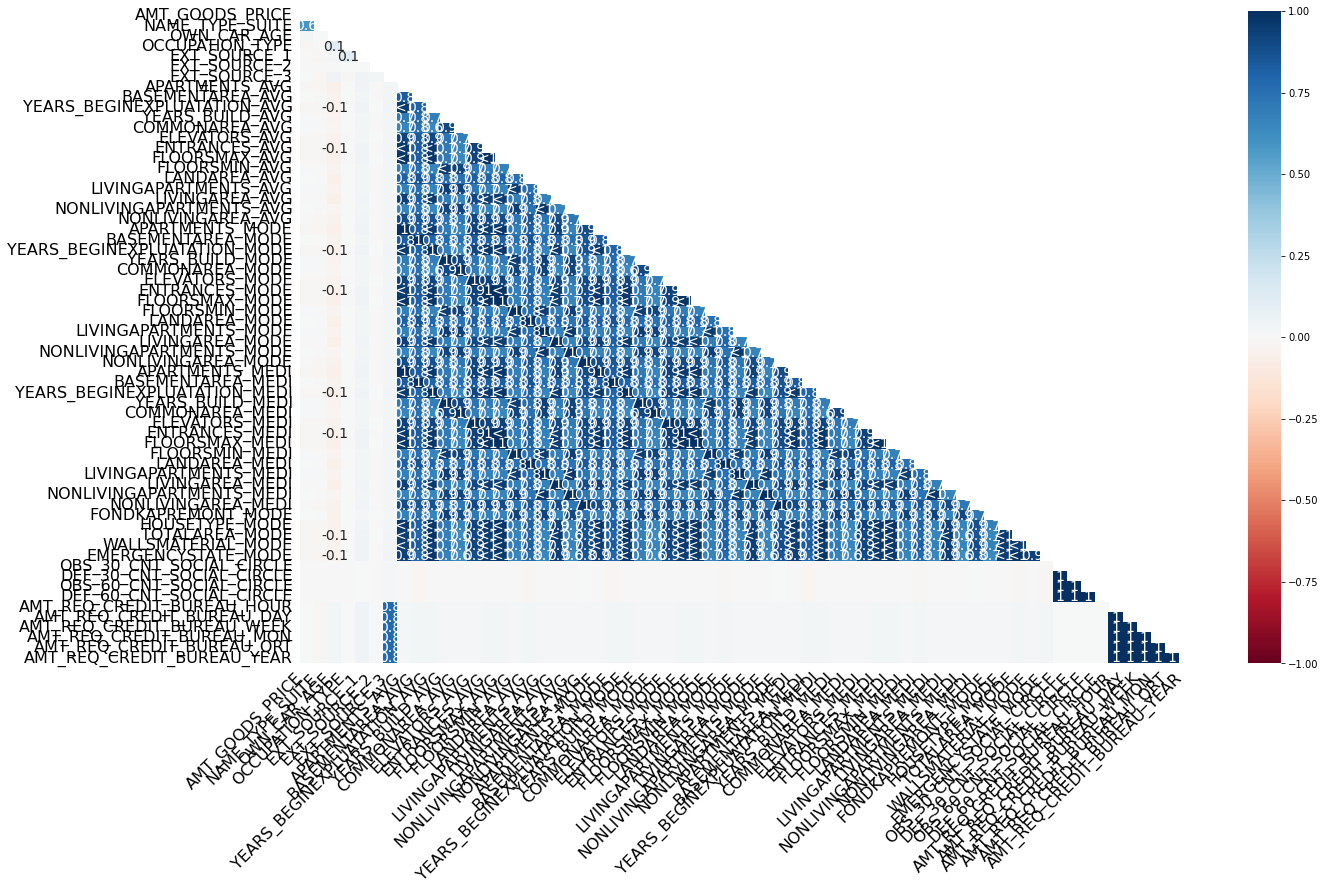

In [ ]:
# Trop de colonnes ici, ne rend pas bien

msno.heatmap(train_eda)
# Il s'agit des corrélations sur les valeurs manquantes

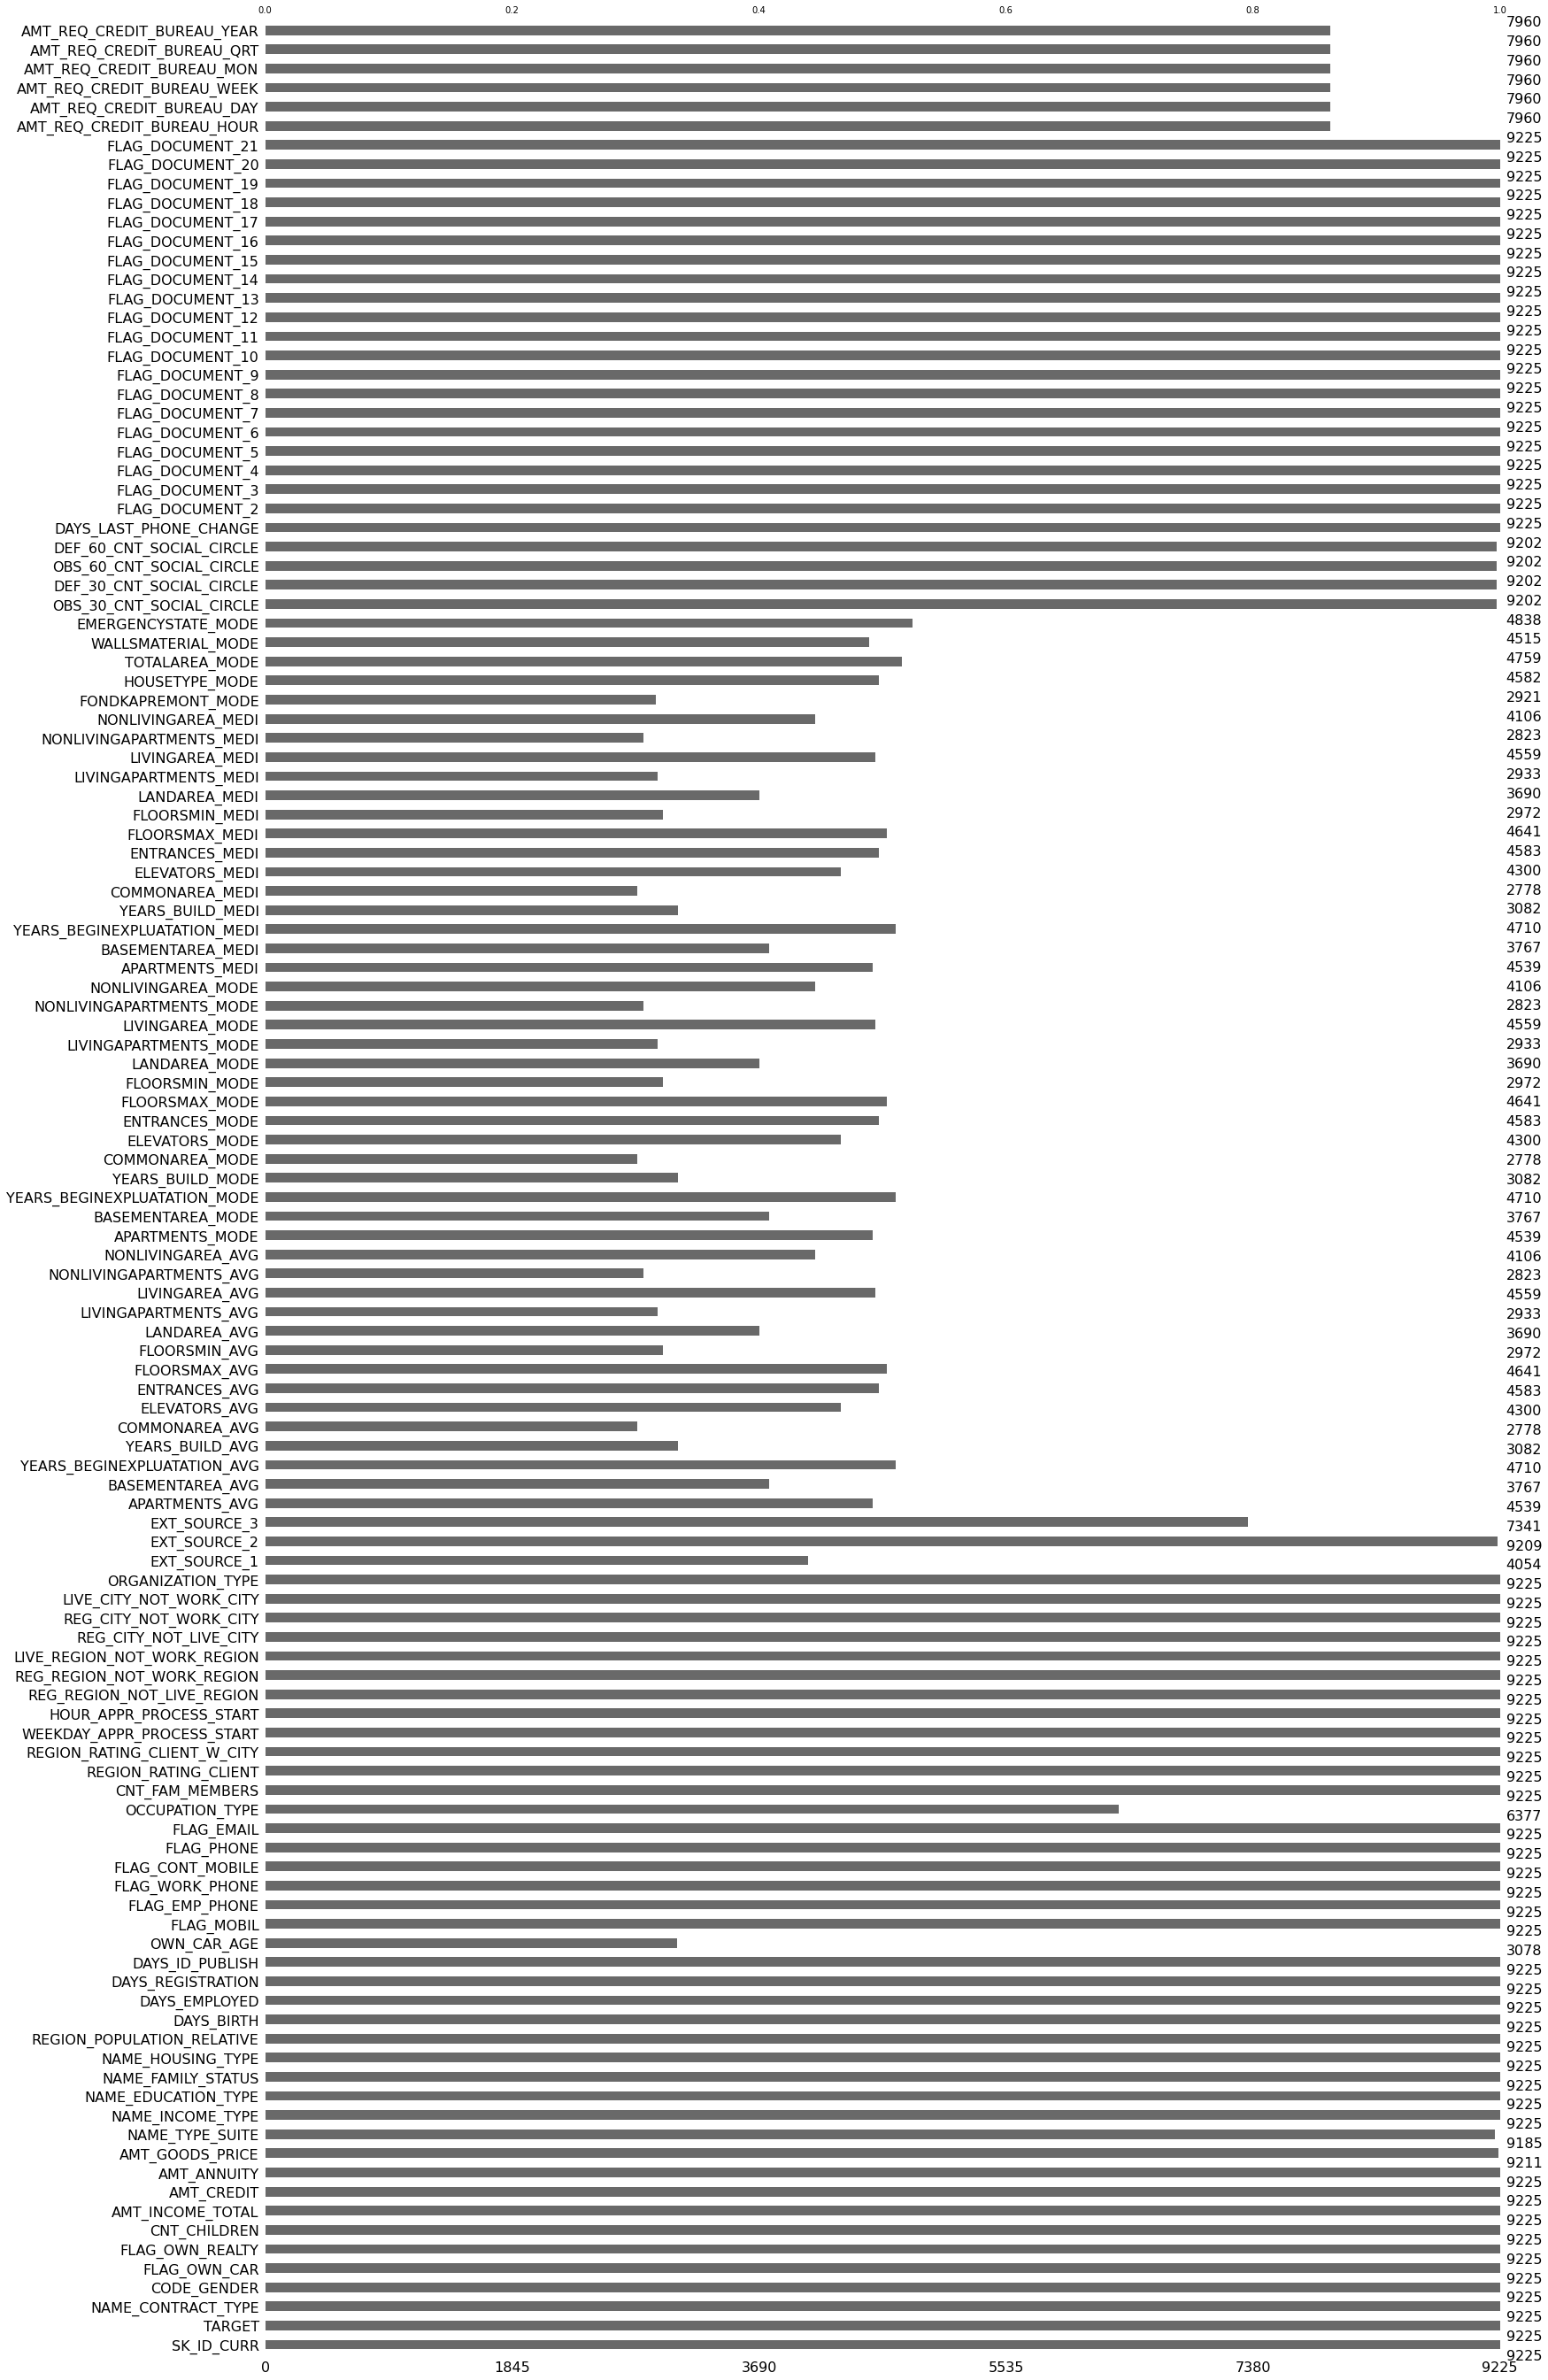

In [ ]:
msno.bar(train_eda)
# Les barres sont proportionnelles au nombre de valeurs non manquantes

## Détection des anomalies
- Cf: https://medium.com/thecyphy/home-credit-default-risk-part-2-84b58c1ab9d5

In [ ]:
train_eda['CNT_CHILDREN'].describe().round(2)
# Pas de valeur anormale ici

count    9225.00
mean        0.41
std         0.74
min         0.00
25%         0.00
50%         0.00
75%         1.00
max        19.00
Name: CNT_CHILDREN, dtype: float64

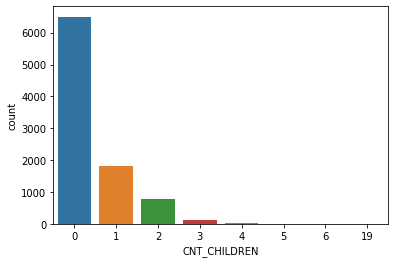

In [ ]:
# Je représente la distribution de cette colonne:
sns.countplot(x='CNT_CHILDREN', data=train_eda)
plt.show()

In [ ]:
train_eda['AMT_INCOME_TOTAL'].describe().round(2)
# Pas de valeur anormale ici

count       9225.00
mean      168075.67
std        94213.28
min        29133.00
25%       112500.00
50%       148500.00
75%       202500.00
max      1890000.00
Name: AMT_INCOME_TOTAL, dtype: float64

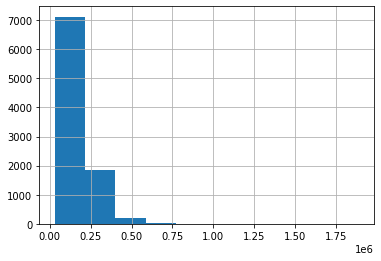

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['AMT_INCOME_TOTAL'].hist()
plt.show()

In [ ]:
# Pas de valeurs dans ce sample

# J'affiche les quelques valeurs aberrantes à mon sens (supérieures à 1e+07)
train_eda[train_eda['AMT_INCOME_TOTAL']>1e+07][['AMT_INCOME_TOTAL']]

Empty DataFrame
Columns: [AMT_INCOME_TOTAL]
Index: []

In [ ]:
# Pas de valeurs dans ce sample, donc je n'exécute pas

# Il y a peu de lignes pour lesquelles le montant est très élevé: je ne vais pas les considérer
#app_train = app_train[app_train['AMT_INCOME_TOTAL']<=1e+07]

# Je réindexe ensuite
#app_train = app_train.reset_index(drop = True)

In [ ]:
train_eda['AMT_CREDIT'].describe().round(2)
# Pas de valeur anormale ici

count       9225.00
mean      597552.78
std       400018.43
min        45000.00
25%       270000.00
50%       517500.00
75%       808650.00
max      2695500.00
Name: AMT_CREDIT, dtype: float64

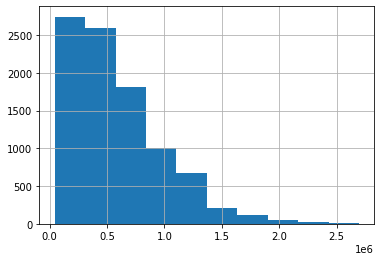

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['AMT_CREDIT'].hist()
plt.show()

In [ ]:
train_eda['AMT_ANNUITY'].describe().round(2)
# Pas de valeur anormale ici

count      9225.00
mean      27042.40
std       14429.78
min        3006.00
25%       16587.00
50%       24925.50
75%       34578.00
max      225000.00
Name: AMT_ANNUITY, dtype: float64

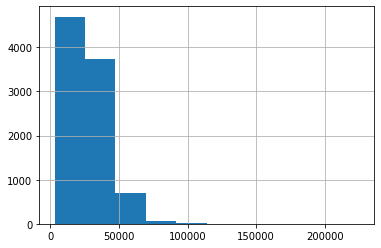

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['AMT_ANNUITY'].hist()
plt.show()

In [ ]:
train_eda['AMT_GOODS_PRICE'].describe().round(2)
# Pas de valeur anormale ici

count       9211.00
mean      536790.61
std       366809.52
min        45000.00
25%       238500.00
50%       450000.00
75%       679500.00
max      2475000.00
Name: AMT_GOODS_PRICE, dtype: float64

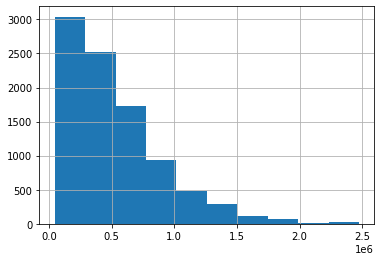

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['AMT_GOODS_PRICE'].hist()
plt.show()

In [ ]:
train_eda['REGION_POPULATION_RELATIVE'].describe().round(2)
# Pas de valeur anormale ici

count    9225.00
mean        0.02
std         0.01
min         0.00
25%         0.01
50%         0.02
75%         0.03
max         0.07
Name: REGION_POPULATION_RELATIVE, dtype: float64

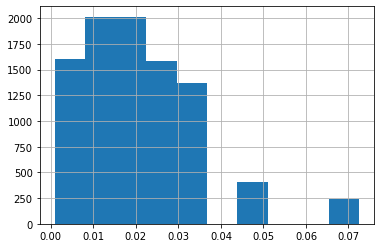

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['REGION_POPULATION_RELATIVE'].hist()
plt.show()

In [ ]:
train_eda['DAYS_BIRTH'].describe().round(2)
# Pour voir les stats en années, on peut donc multiplier par -1 et diviser par le nombre (approximatif) de jours dans une année

count     9225.00
mean    -16012.95
std       4361.77
min     -25192.00
25%     -19666.00
50%     -15734.00
75%     -12351.00
max      -7680.00
Name: DAYS_BIRTH, dtype: float64

In [ ]:
(train_eda['DAYS_BIRTH'] / -365).describe().round(2)
# Pas de valeur anormale ici

count    9225.00
mean       43.87
std        11.95
min        21.04
25%        33.84
50%        43.11
75%        53.88
max        69.02
Name: DAYS_BIRTH, dtype: float64

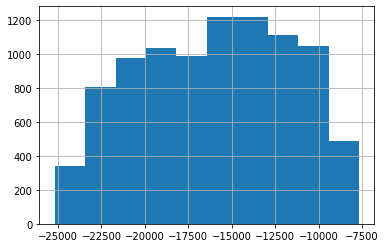

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['DAYS_BIRTH'].hist()
plt.show()

In [ ]:
train_eda['DAYS_EMPLOYED'].describe().round(2)
# Pour voir les stats en années, on peut donc diviser par le nombre (approximatif) de jours dans une année

count      9225.00
mean      62110.87
std      139879.57
min      -17546.00
25%       -2750.00
50%       -1215.00
75%        -310.00
max      365243.00
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
(train_eda['DAYS_EMPLOYED'] / 365).describe().round(2)
# Il y a des anomalies ici (valeurs négatives et positives, et maximum 1000 ans)

count    9225.00
mean      170.17
std       383.23
min       -48.07
25%        -7.53
50%        -3.33
75%        -0.85
max      1000.67
Name: DAYS_EMPLOYED, dtype: float64

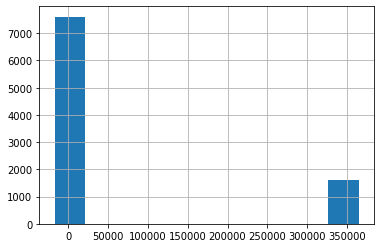

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['DAYS_EMPLOYED'].hist()
plt.show()

In [ ]:
# On sépare le jeu de données en deux: les données anormales d'après ce critère, et les autres
anom = train_eda[train_eda['DAYS_EMPLOYED'] == 365243]
non_anom = train_eda[train_eda['DAYS_EMPLOYED'] != 365243]

# On regarde leur comportement vis a vis des prêts
print('Les individus non anormaux ont un soucis sur %0.2f%% des prêts' % (100 * non_anom['TARGET'].mean()))
print('Les individus anormaux ont un soucis sur %0.2f%% des prêts' % (100 * anom['TARGET'].mean()))
print('Il y a %d jours anormaux d\'emploi' % len(anom))

Les individus non anormaux ont un soucis sur 8.45% des prêts
Les individus anormaux ont un soucis sur 4.20% des prêts
Il y a 1619 jours anormaux d'emploi


Il s'avère que les individus anormaux ont un taux plus faible de défaut de paiement.

Nous allons donc ici remplacer ces valeurs anormales par un np.nan, tout en créant une nouvelle colonne qui contiendra un booléen de l'ancienne colonne, à savoir si la ligne était anormale ou non afin que le futur modèle puisse considérer cette anomalie, et voir si elle a de l'importance.

In [ ]:
# Fonction pour créer la colonne DAYS_EMPLOYED_ANOM
def create_days_emp_anom(df):
  # Création de la colonne flag:
  df['DAYS_EMPLOYED_ANOM'] = df['DAYS_EMPLOYED']==365243
  # On remplace les valeurs par np.nan
  df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

  return df

In [ ]:
# On applique sur les jeux de données
train_eda = create_days_emp_anom(train_eda)
test_eda = create_days_emp_anom(test_eda)

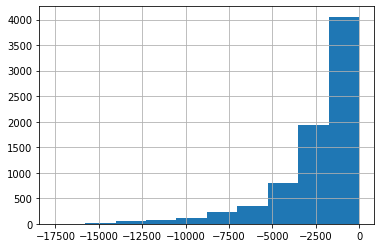

In [ ]:
# On représente le nouvel histogramme
train_eda['DAYS_EMPLOYED'].hist()
plt.show()

In [ ]:
train_eda['DAYS_REGISTRATION'].describe().round(2)
# Pour voir les stats en années, on peut donc multiplier par -1 et diviser par le nombre (approximatif) de jours dans une année

count     9225.00
mean     -4975.50
std       3533.47
min     -22858.00
25%      -7500.00
50%      -4505.00
75%      -1954.00
max          0.00
Name: DAYS_REGISTRATION, dtype: float64

In [ ]:
(train_eda['DAYS_REGISTRATION'] / -365).describe().round(2)
# Pas de valeur anormale ici

count    9225.00
mean       13.63
std         9.68
min        -0.00
25%         5.35
50%        12.34
75%        20.55
max        62.62
Name: DAYS_REGISTRATION, dtype: float64

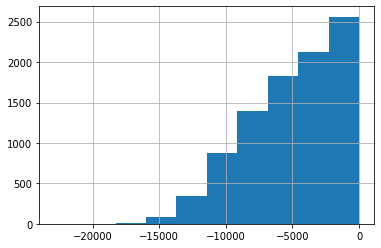

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['DAYS_REGISTRATION'].hist()
plt.show()

In [ ]:
train_eda['DAYS_ID_PUBLISH'].describe().round(2)
# Pour voir les stats en années, on peut donc multiplier par -1 et diviser par le nombre (approximatif) de jours dans une année

count    9225.00
mean    -2980.90
std      1512.84
min     -6208.00
25%     -4290.00
50%     -3230.00
75%     -1702.00
max        -1.00
Name: DAYS_ID_PUBLISH, dtype: float64

In [ ]:
(train_eda['DAYS_ID_PUBLISH'] / -365).describe().round(2)
# Pas de valeur anormale ici

count    9225.00
mean        8.17
std         4.14
min         0.00
25%         4.66
50%         8.85
75%        11.75
max        17.01
Name: DAYS_ID_PUBLISH, dtype: float64

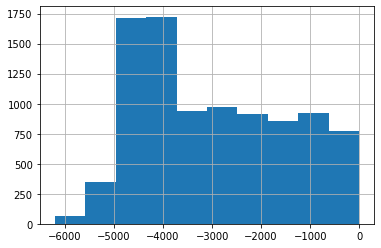

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['DAYS_ID_PUBLISH'].hist()
plt.show()

In [ ]:
train_eda['OWN_CAR_AGE'].describe().round(2)
# Pas de valeur anormale ici

count    3078.00
mean       11.99
std        11.76
min         0.00
25%         5.00
50%         9.00
75%        15.00
max        65.00
Name: OWN_CAR_AGE, dtype: float64

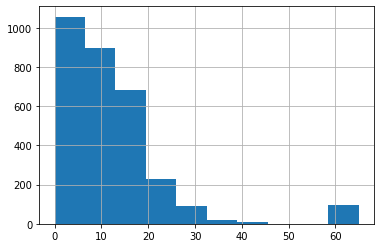

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['OWN_CAR_AGE'].hist()
plt.show()

In [ ]:
train_eda['CNT_FAM_MEMBERS'].describe().round(2)
# Pas de valeur anormale ici

count    9225.00
mean        2.15
std         0.93
min         1.00
25%         2.00
50%         2.00
75%         3.00
max        20.00
Name: CNT_FAM_MEMBERS, dtype: float64

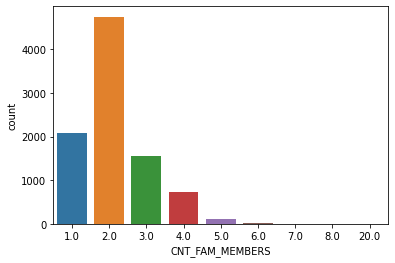

In [ ]:
# Je représente la distribution de cette colonne:
sns.countplot(x='CNT_FAM_MEMBERS', data=train_eda)
plt.show()

In [ ]:
train_eda['REGION_RATING_CLIENT'].describe().round(2)
# Pas de valeur anormale ici

count    9225.00
mean        2.05
std         0.51
min         1.00
25%         2.00
50%         2.00
75%         2.00
max         3.00
Name: REGION_RATING_CLIENT, dtype: float64

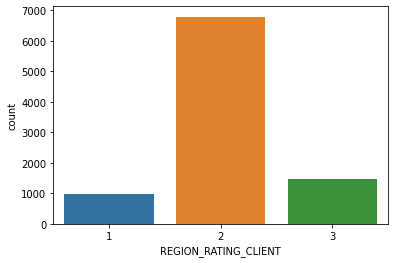

In [ ]:
# Je représente la distribution de cette colonne:
sns.countplot(x='REGION_RATING_CLIENT', data=train_eda)
plt.show()

In [ ]:
train_eda['REGION_RATING_CLIENT_W_CITY'].describe().round(2)
# Pas de valeur anormale ici

count    9225.00
mean        2.03
std         0.51
min         1.00
25%         2.00
50%         2.00
75%         2.00
max         3.00
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64

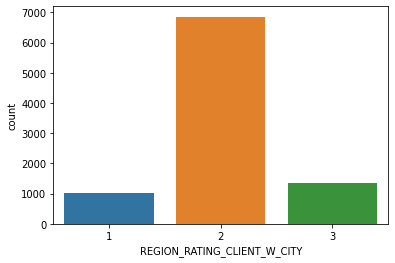

In [ ]:
# Je représente la distribution de cette colonne:
sns.countplot(x='REGION_RATING_CLIENT_W_CITY', data=train_eda)
plt.show()

In [ ]:
# Vérifier s'il s'agit d'une anomalie ici
train_eda[train_eda['REGION_RATING_CLIENT']!=train_eda['REGION_RATING_CLIENT_W_CITY']]

SK_ID_CURR  TARGET  ... AMT_REQ_CREDIT_BUREAU_YEAR DAYS_EMPLOYED_ANOM
5         353727       0  ...                        1.0              False
364       102766       0  ...                        0.0               True
366       434805       0  ...                        2.0              False
375       252362       0  ...                        8.0              False
385       268872       0  ...                        5.0              False
...          ...     ...  ...                        ...                ...
8699      315510       0  ...                        0.0               True
8762      362145       0  ...                        0.0              False
8915      399552       0  ...                        1.0              False
8953      316784       0  ...                        2.0              False
9003      349818       0  ...                        0.0               True

[170 rows x 123 columns]

In [ ]:
train_eda['HOUR_APPR_PROCESS_START'].describe().round(2)
# Pas de valeur anormale ici

count    9225.00
mean       12.05
std         3.27
min         1.00
25%        10.00
50%        12.00
75%        14.00
max        23.00
Name: HOUR_APPR_PROCESS_START, dtype: float64

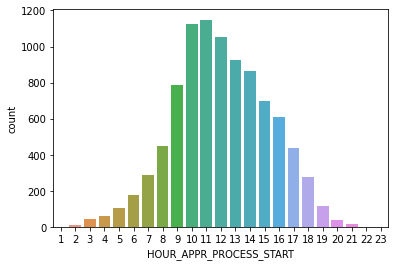

In [ ]:
# Je représente la distribution de cette colonne:
sns.countplot(x='HOUR_APPR_PROCESS_START', data=train_eda)
plt.show()

A partir d'ici, il semble s'agir de scores, compris entre 0 et 1.

In [ ]:
train_eda[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].describe().round(2)
# Pas de valeur anormale ici

EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3
count       4054.00       9209.00       7341.00
mean           0.50          0.51          0.50
std            0.21          0.19          0.19
min            0.03          0.00          0.00
25%            0.33          0.39          0.36
50%            0.50          0.56          0.52
75%            0.67          0.66          0.66
max            0.93          0.85          0.88

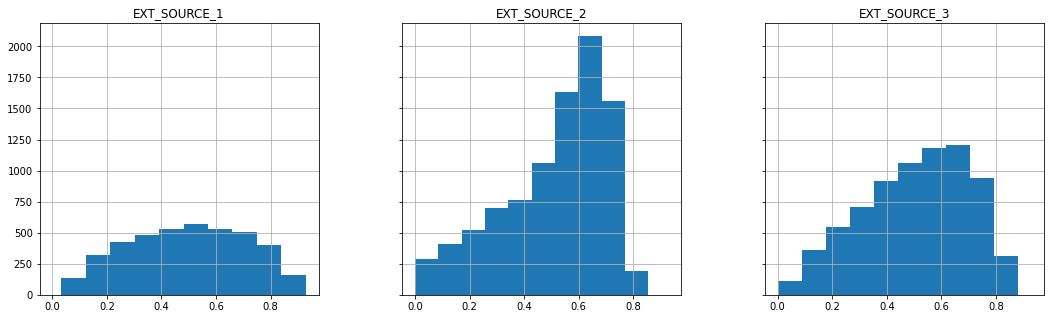

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['APARTMENTS_AVG', 'APARTMENTS_MODE', 'APARTMENTS_MEDI']].describe().round(2)
# Pas de valeur anormale ici

APARTMENTS_AVG  APARTMENTS_MODE  APARTMENTS_MEDI
count         4539.00          4539.00          4539.00
mean             0.12             0.11             0.12
std              0.11             0.11             0.11
min              0.00             0.00             0.00
25%              0.06             0.05             0.06
50%              0.09             0.08             0.09
75%              0.15             0.14             0.15
max              1.00             1.00             1.00

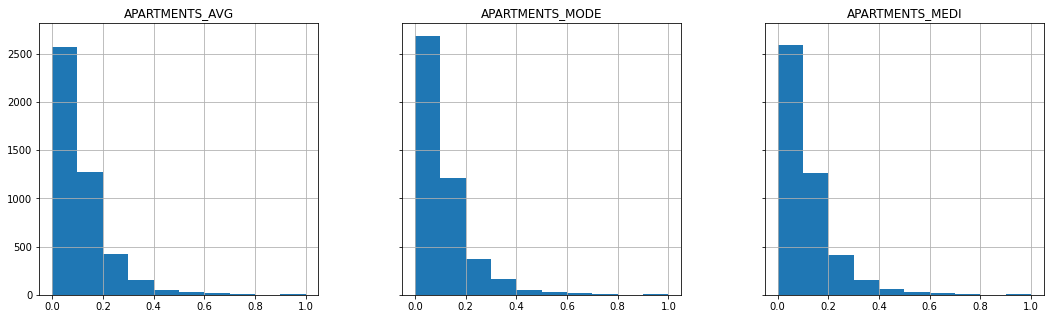

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['APARTMENTS_AVG', 'APARTMENTS_MODE', 'APARTMENTS_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['BASEMENTAREA_AVG', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MEDI']].describe().round(2)
# Pas de valeur anormale ici

BASEMENTAREA_AVG  BASEMENTAREA_MODE  BASEMENTAREA_MEDI
count           3767.00            3767.00            3767.00
mean               0.09               0.09               0.09
std                0.09               0.09               0.09
min                0.00               0.00               0.00
25%                0.04               0.04               0.04
50%                0.08               0.07               0.08
75%                0.11               0.11               0.11
max                1.00               1.00               1.00

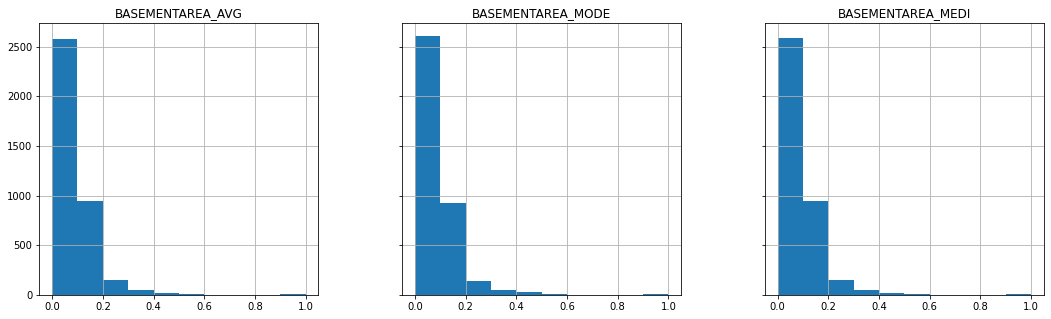

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['BASEMENTAREA_AVG', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI']].describe().round(2)
# Pas de valeur anormale ici

YEARS_BEGINEXPLUATATION_AVG  ...  YEARS_BEGINEXPLUATATION_MEDI
count                      4710.00  ...                       4710.00
mean                          0.98  ...                          0.98
std                           0.06  ...                          0.06
min                           0.00  ...                          0.00
25%                           0.98  ...                          0.98
50%                           0.98  ...                          0.98
75%                           0.99  ...                          0.99
max                           1.00  ...                          1.00

[8 rows x 3 columns]

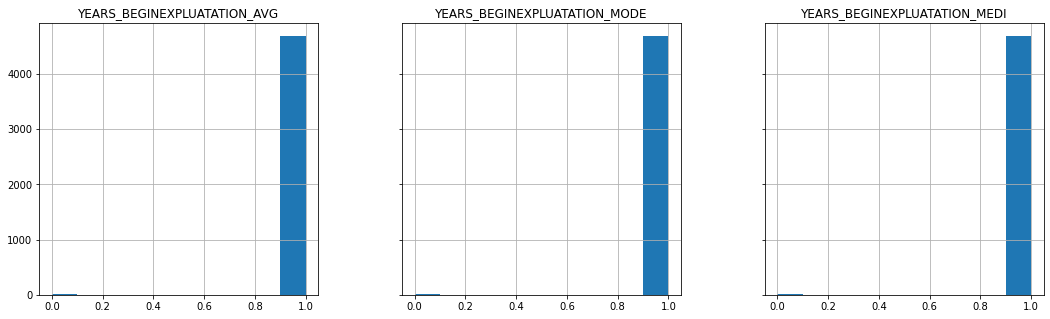

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI']].describe().round(2)
# Pas de valeur anormale ici

YEARS_BUILD_AVG  YEARS_BUILD_MODE  YEARS_BUILD_MEDI
count          3082.00           3082.00           3082.00
mean              0.75              0.76              0.75
std               0.11              0.11              0.11
min               0.00              0.00              0.00
25%               0.69              0.69              0.69
50%               0.76              0.76              0.76
75%               0.82              0.82              0.82
max               1.00              1.00              1.00

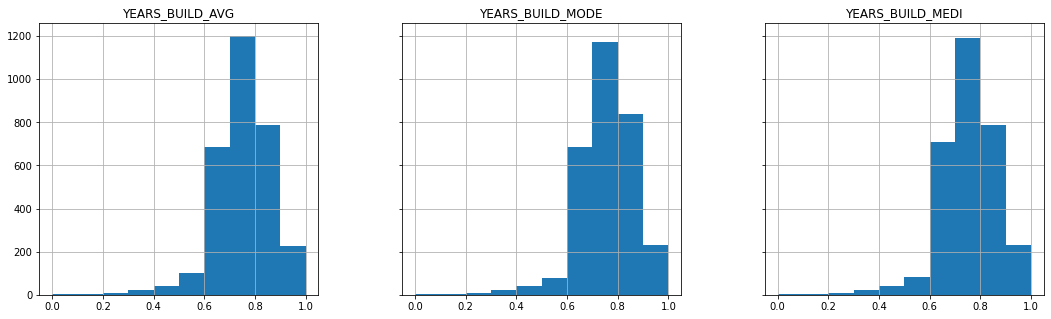

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['COMMONAREA_AVG', 'COMMONAREA_MODE', 'COMMONAREA_MEDI']].describe().round(2)
# Pas de valeur anormale ici

COMMONAREA_AVG  COMMONAREA_MODE  COMMONAREA_MEDI
count         2778.00          2778.00          2778.00
mean             0.04             0.04             0.04
std              0.08             0.08             0.08
min              0.00             0.00             0.00
25%              0.01             0.01             0.01
50%              0.02             0.02             0.02
75%              0.05             0.05             0.05
max              1.00             1.00             1.00

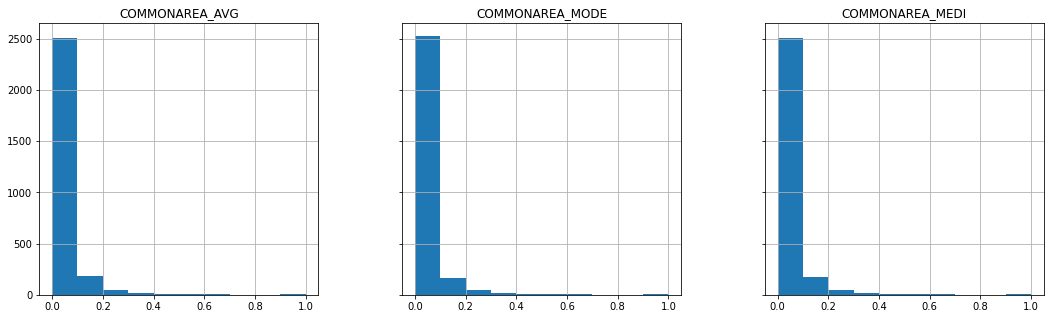

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['COMMONAREA_AVG', 'COMMONAREA_MODE', 'COMMONAREA_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['ELEVATORS_AVG', 'ELEVATORS_MODE', 'ELEVATORS_MEDI']].describe().round(2)
# Pas de valeur anormale ici

ELEVATORS_AVG  ELEVATORS_MODE  ELEVATORS_MEDI
count        4300.00         4300.00         4300.00
mean            0.08            0.07            0.08
std             0.13            0.13            0.13
min             0.00            0.00            0.00
25%             0.00            0.00            0.00
50%             0.00            0.00            0.00
75%             0.12            0.12            0.12
max             1.00            1.00            1.00

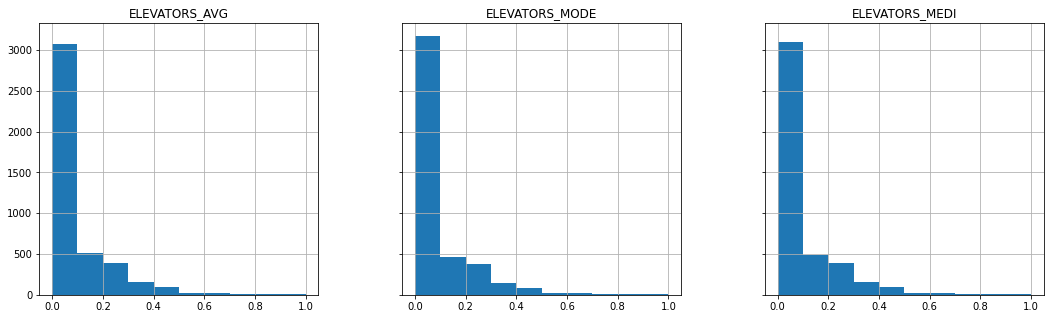

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['ELEVATORS_AVG', 'ELEVATORS_MODE', 'ELEVATORS_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['ENTRANCES_AVG', 'ENTRANCES_MODE', 'ENTRANCES_MEDI']].describe().round(2)
# Pas de valeur anormale ici

ENTRANCES_AVG  ENTRANCES_MODE  ENTRANCES_MEDI
count        4583.00         4583.00         4583.00
mean            0.15            0.14            0.15
std             0.10            0.10            0.10
min             0.00            0.00            0.00
25%             0.07            0.07            0.07
50%             0.14            0.14            0.14
75%             0.21            0.21            0.21
max             1.00            1.00            1.00

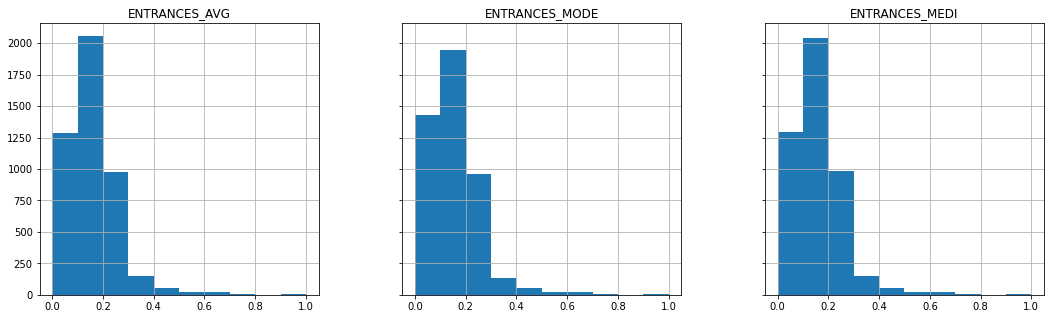

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['ENTRANCES_AVG', 'ENTRANCES_MODE', 'ENTRANCES_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI']].describe().round(2)
# Pas de valeur anormale ici

FLOORSMAX_AVG  FLOORSMAX_MODE  FLOORSMAX_MEDI
count        4641.00         4641.00         4641.00
mean            0.22            0.22            0.22
std             0.14            0.14            0.14
min             0.00            0.00            0.00
25%             0.17            0.17            0.17
50%             0.17            0.17            0.17
75%             0.33            0.33            0.33
max             1.00            1.00            1.00

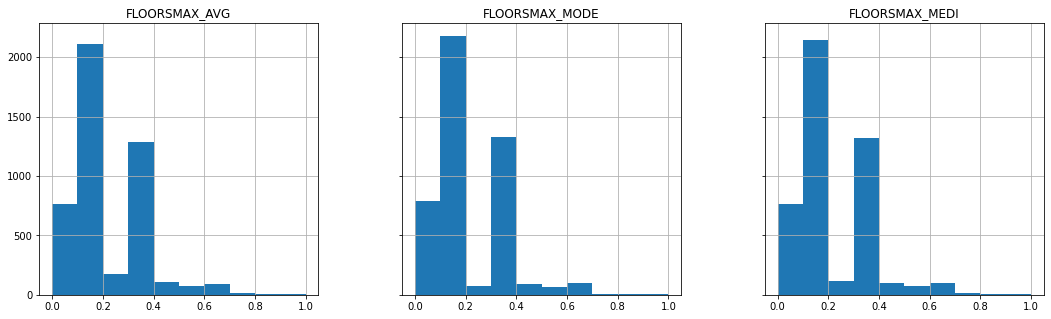

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['FLOORSMIN_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI']].describe().round(2)
# Pas de valeur anormale ici

FLOORSMIN_AVG  FLOORSMIN_MODE  FLOORSMIN_MEDI
count        2972.00         2972.00         2972.00
mean            0.22            0.22            0.22
std             0.15            0.15            0.15
min             0.00            0.00            0.00
25%             0.08            0.08            0.08
50%             0.21            0.21            0.21
75%             0.38            0.38            0.38
max             1.00            1.00            1.00

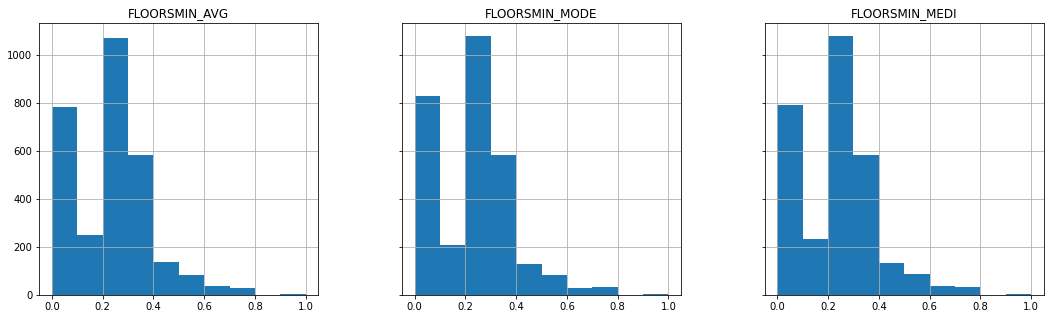

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['FLOORSMIN_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['LANDAREA_AVG', 'LANDAREA_MODE', 'LANDAREA_MEDI']].describe().round(2)
# Pas de valeur anormale ici

LANDAREA_AVG  LANDAREA_MODE  LANDAREA_MEDI
count       3690.00        3690.00        3690.00
mean           0.07           0.06           0.07
std            0.08           0.08           0.08
min            0.00           0.00           0.00
25%            0.02           0.02           0.02
50%            0.05           0.04           0.05
75%            0.08           0.08           0.09
max            1.00           1.00           1.00

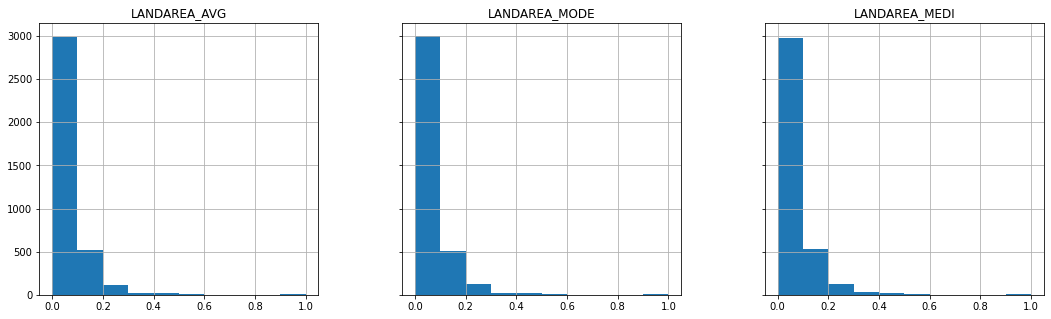

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['LANDAREA_AVG', 'LANDAREA_MODE', 'LANDAREA_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI']].describe().round(2)
# Pas de valeur anormale ici

LIVINGAPARTMENTS_AVG  LIVINGAPARTMENTS_MODE  LIVINGAPARTMENTS_MEDI
count               2933.00                2933.00                2933.00
mean                   0.10                   0.10                   0.10
std                    0.10                   0.10                   0.10
min                    0.00                   0.00                   0.00
25%                    0.05                   0.05                   0.05
50%                    0.07                   0.07                   0.08
75%                    0.12                   0.13                   0.12
max                    1.00                   1.00                   1.00

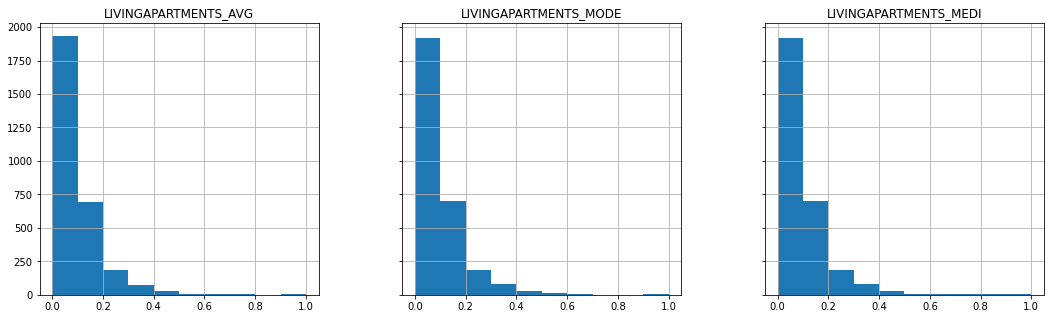

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI']].describe().round(2)
# Pas de valeur anormale ici

LIVINGAREA_AVG  LIVINGAREA_MODE  LIVINGAREA_MEDI
count         4559.00          4559.00          4559.00
mean             0.11             0.10             0.11
std              0.11             0.11             0.11
min              0.00             0.00             0.00
25%              0.05             0.04             0.05
50%              0.07             0.07             0.07
75%              0.13             0.12             0.13
max              1.00             1.00             1.00

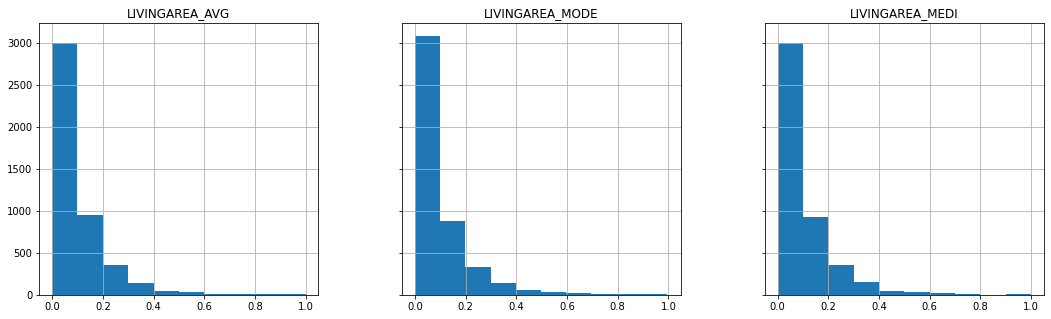

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI']].describe().round(2)
# Pas de valeur anormale ici

NONLIVINGAPARTMENTS_AVG  ...  NONLIVINGAPARTMENTS_MEDI
count                  2823.00  ...                   2823.00
mean                      0.01  ...                      0.01
std                       0.04  ...                      0.04
min                       0.00  ...                      0.00
25%                       0.00  ...                      0.00
50%                       0.00  ...                      0.00
75%                       0.01  ...                      0.00
max                       1.00  ...                      1.00

[8 rows x 3 columns]

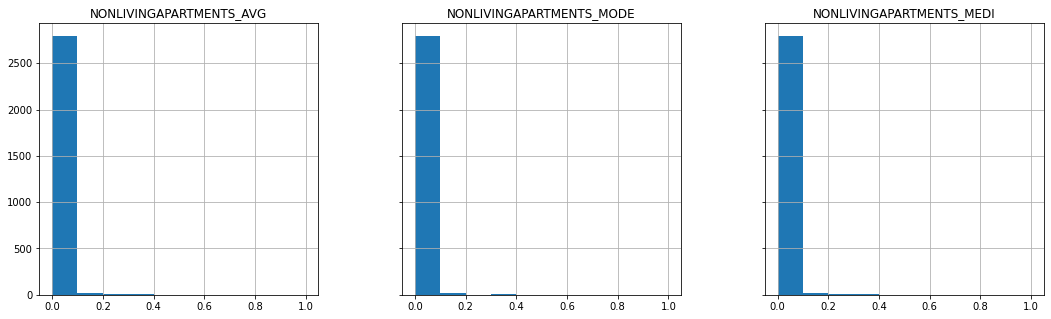

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda[['NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_MEDI']].describe().round(2)
# Pas de valeur anormale ici

NONLIVINGAREA_AVG  NONLIVINGAREA_MODE  NONLIVINGAREA_MEDI
count            4106.00             4106.00             4106.00
mean                0.03                0.03                0.03
std                 0.07                0.07                0.07
min                 0.00                0.00                0.00
25%                 0.00                0.00                0.00
50%                 0.00                0.00                0.00
75%                 0.03                0.02                0.03
max                 1.00                1.00                1.00

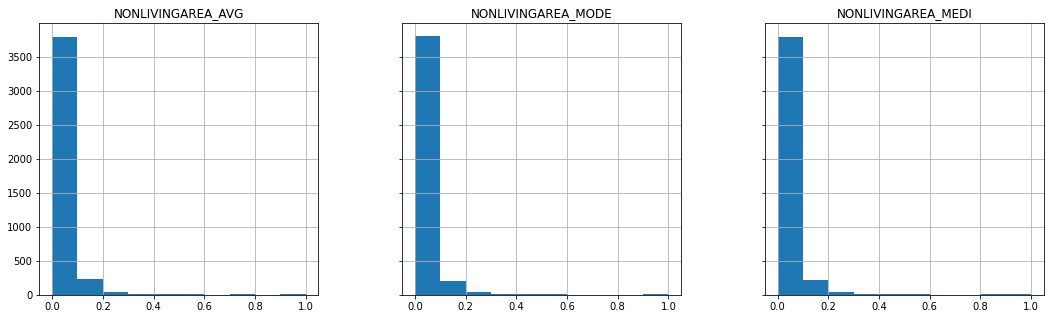

In [ ]:
# Je représente la distribution de ces colonnes:
train_eda[['NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_MEDI']].hist(sharex=True, sharey=True, figsize=(18,5), layout=(1,3))
plt.show()

In [ ]:
train_eda['TOTALAREA_MODE'].describe().round(2)
# Pas de valeur anormale ici

count    4759.00
mean        0.10
std         0.11
min         0.00
25%         0.04
50%         0.07
75%         0.13
max         1.00
Name: TOTALAREA_MODE, dtype: float64

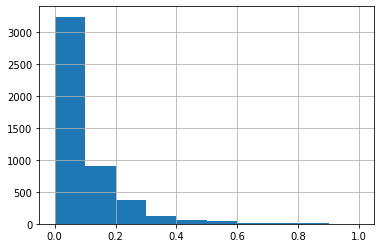

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['TOTALAREA_MODE'].hist()
plt.show()

In [ ]:
train_eda['OBS_30_CNT_SOCIAL_CIRCLE'].describe().round(2)
# Pas de valeur anormale ici

count    9202.00
mean        1.42
std         2.32
min         0.00
25%         0.00
50%         0.00
75%         2.00
max        22.00
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

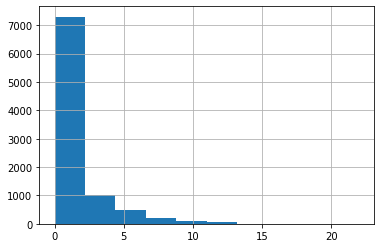

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['OBS_30_CNT_SOCIAL_CIRCLE'].hist()
plt.show()

In [ ]:
train_eda['DEF_30_CNT_SOCIAL_CIRCLE'].describe().round(2)
# Pas de valeur anormale ici

count    9202.00
mean        0.15
std         0.45
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         4.00
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

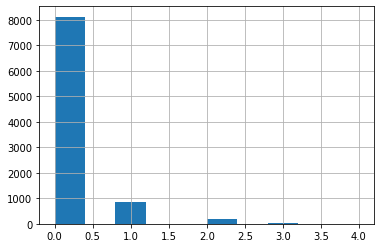

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['DEF_30_CNT_SOCIAL_CIRCLE'].hist()
plt.show()

In [ ]:
train_eda['OBS_60_CNT_SOCIAL_CIRCLE'].describe().round(2)
# Pas de valeur anormale ici

count    9202.00
mean        1.41
std         2.30
min         0.00
25%         0.00
50%         0.00
75%         2.00
max        22.00
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64

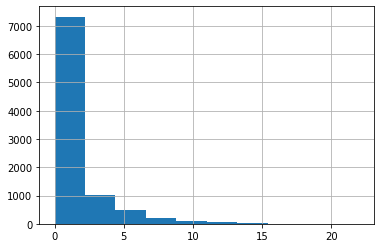

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['OBS_60_CNT_SOCIAL_CIRCLE'].hist()
plt.show()

In [ ]:
train_eda['DEF_60_CNT_SOCIAL_CIRCLE'].describe().round(2)
# Pas de valeur anormale ici

count    9202.00
mean        0.10
std         0.36
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         4.00
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: float64

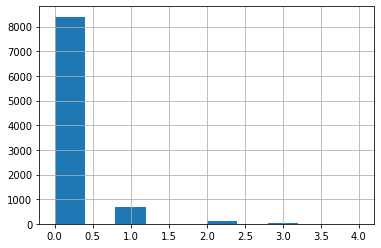

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['DEF_60_CNT_SOCIAL_CIRCLE'].hist()
plt.show()

In [ ]:
train_eda['DAYS_LAST_PHONE_CHANGE'].describe().round(2)
# Pas de valeur anormale ici

count    9225.00
mean     -957.98
std       819.15
min     -3808.00
25%     -1558.00
50%      -761.00
75%      -281.00
max         0.00
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

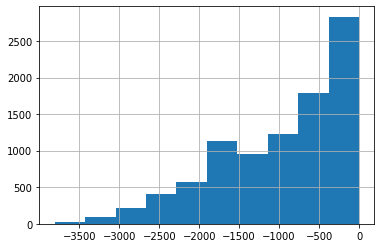

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['DAYS_LAST_PHONE_CHANGE'].hist()
plt.show()

In [ ]:
train_eda['AMT_REQ_CREDIT_BUREAU_HOUR'].describe().round(2)
# Pas de valeur anormale ici

count    7960.00
mean        0.01
std         0.09
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         2.00
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: float64

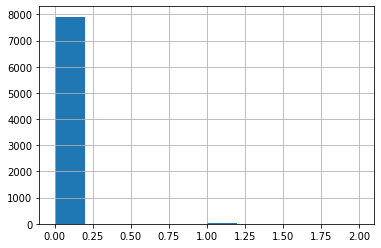

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['AMT_REQ_CREDIT_BUREAU_HOUR'].hist()
plt.show()

In [ ]:
train_eda['AMT_REQ_CREDIT_BUREAU_DAY'].describe().round(2)
# Pas de valeur anormale ici

count    7960.00
mean        0.01
std         0.12
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         5.00
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64

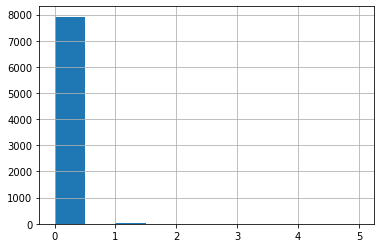

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['AMT_REQ_CREDIT_BUREAU_DAY'].hist()
plt.show()

In [ ]:
train_eda['AMT_REQ_CREDIT_BUREAU_WEEK'].describe().round(2)
# Pas de valeur anormale ici

count    7960.00
mean        0.04
std         0.21
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         6.00
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64

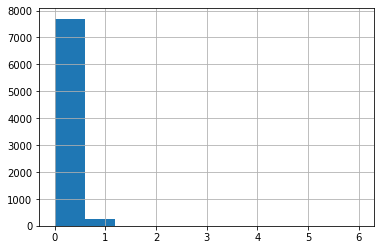

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['AMT_REQ_CREDIT_BUREAU_WEEK'].hist()
plt.show()

In [ ]:
train_eda['AMT_REQ_CREDIT_BUREAU_MON'].describe().round(2)
# Pas de valeur anormale ici

count    7960.00
mean        0.28
std         0.90
min         0.00
25%         0.00
50%         0.00
75%         0.00
max        14.00
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: float64

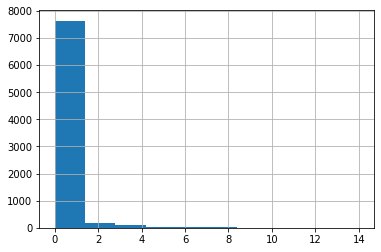

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['AMT_REQ_CREDIT_BUREAU_MON'].hist()
plt.show()

In [ ]:
train_eda['AMT_REQ_CREDIT_BUREAU_QRT'].describe().round(2)
# Pas de valeur anormale ici

count    7960.00
mean        0.27
std         0.62
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         8.00
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64

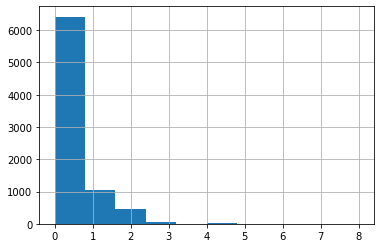

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['AMT_REQ_CREDIT_BUREAU_QRT'].hist()
plt.show()

In [ ]:
train_eda['AMT_REQ_CREDIT_BUREAU_YEAR'].describe().round(2)
# Pas de valeur anormale ici

count    7960.00
mean        1.89
std         1.84
min         0.00
25%         0.00
50%         1.00
75%         3.00
max        14.00
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64

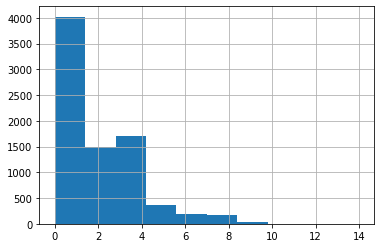

In [ ]:
# Je représente la distribution de cette colonne:
train_eda['AMT_REQ_CREDIT_BUREAU_YEAR'].hist()
plt.show()

## Traitement des valeurs manquantes

In [ ]:
# Nombre de colonnes de chaque type
train_eda.dtypes.value_counts()

float64    66
int64      40
object     16
bool        1
dtype: int64

### Colonnes qualitatives

In [ ]:
# Fonction pour remplacer les valeurs manquantes par une autre valeur donnée
def fill_by_value(df_col, value_fill):
  df_col.fillna(value=value_fill, inplace=True)

  return df_col

In [ ]:
# Nombre de valeurs distinctes dans les colonnes objet
train_eda.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               5
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [ ]:
train_eda['NAME_CONTRACT_TYPE'].unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

In [ ]:
train_eda['CODE_GENDER'].unique()

array(['M', 'F'], dtype=object)

In [ ]:
train_eda['NAME_TYPE_SUITE'].unique()

array(['Unaccompanied', 'Children', 'Spouse, partner', 'Other_A',
       'Family', nan, 'Other_B', 'Group of people'], dtype=object)

In [ ]:
# On remplace les valeurs manquantes par Unknown
train_eda['NAME_TYPE_SUITE'] = fill_by_value(train_eda['NAME_TYPE_SUITE'], "Unknown")

In [ ]:
train_eda['NAME_INCOME_TYPE'].unique()

array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
       'Businessman'], dtype=object)

In [ ]:
train_eda['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Lower secondary', 'Incomplete higher', 'Academic degree'],
      dtype=object)

In [ ]:
train_eda['NAME_FAMILY_STATUS'].unique()

array(['Married', 'Widow', 'Single / not married', 'Civil marriage',
       'Separated'], dtype=object)

In [ ]:
train_eda['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'With parents', 'Municipal apartment',
       'Office apartment', 'Rented apartment', 'Co-op apartment'],
      dtype=object)

In [ ]:
train_eda['OCCUPATION_TYPE'].unique()

array(['Security staff', 'Managers', 'High skill tech staff',
       'Accountants', 'Laborers', 'Drivers', nan, 'Sales staff',
       'Medicine staff', 'Cooking staff', 'Core staff', 'Cleaning staff',
       'Low-skill Laborers', 'Waiters/barmen staff',
       'Private service staff', 'Realty agents', 'IT staff',
       'Secretaries', 'HR staff'], dtype=object)

In [ ]:
# On remplace les valeurs manquantes par Unknown
train_eda['OCCUPATION_TYPE'] = fill_by_value(train_eda['OCCUPATION_TYPE'], "Unknown")

In [ ]:
train_eda['WEEKDAY_APPR_PROCESS_START'].unique()

array(['THURSDAY', 'TUESDAY', 'FRIDAY', 'MONDAY', 'SATURDAY', 'WEDNESDAY',
       'SUNDAY'], dtype=object)

In [ ]:
train_eda['ORGANIZATION_TYPE'].unique()

array(['Business Entity Type 3', 'Other', 'Business Entity Type 2',
       'Trade: type 3', 'XNA', 'Housing', 'Self-employed', 'Construction',
       'Medicine', 'Trade: type 7', 'Government', 'Transport: type 4',
       'Industry: type 9', 'School', 'Kindergarten', 'Culture',
       'Transport: type 2', 'Military', 'Security Ministries',
       'Industry: type 11', 'Police', 'Transport: type 1',
       'Legal Services', 'Bank', 'Postal', 'Industry: type 3',
       'Transport: type 3', 'Industry: type 1', 'Business Entity Type 1',
       'Agriculture', 'Industry: type 4', 'University', 'Trade: type 2',
       'Industry: type 7', 'Security', 'Restaurant', 'Services',
       'Telecom', 'Electricity', 'Advertising', 'Industry: type 2',
       'Hotel', 'Trade: type 1', 'Religion', 'Realtor', 'Trade: type 6',
       'Insurance', 'Industry: type 5', 'Industry: type 12', 'Mobile',
       'Industry: type 6', 'Emergency', 'Cleaning', 'Industry: type 13',
       'Industry: type 10', 'Trade: type

In [ ]:
train_eda['FONDKAPREMONT_MODE'].unique()

array([nan, 'reg oper account', 'not specified', 'reg oper spec account',
       'org spec account'], dtype=object)

In [ ]:
# On remplace les valeurs manquantes par not specified
train_eda['FONDKAPREMONT_MODE'] = fill_by_value(train_eda['FONDKAPREMONT_MODE'], "not specified")

In [ ]:
train_eda['HOUSETYPE_MODE'].unique()

array([nan, 'block of flats', 'specific housing', 'terraced house'],
      dtype=object)

In [ ]:
# On remplace les valeurs manquantes par Unknown
train_eda['HOUSETYPE_MODE'] = fill_by_value(train_eda['HOUSETYPE_MODE'], "Unknown")

In [ ]:
train_eda['WALLSMATERIAL_MODE'].unique()

array([nan, 'Panel', 'Stone, brick', 'Wooden', 'Block', 'Others', 'Mixed',
       'Monolithic'], dtype=object)

In [ ]:
# On remplace les valeurs manquantes par Others
train_eda['WALLSMATERIAL_MODE'] = fill_by_value(train_eda['WALLSMATERIAL_MODE'], "Others")

In [ ]:
train_eda['EMERGENCYSTATE_MODE'].unique()

array([nan, 'No', 'Yes'], dtype=object)

In [ ]:
# On remplace les valeurs manquantes par Unknown
train_eda['EMERGENCYSTATE_MODE'] = fill_by_value(train_eda['EMERGENCYSTATE_MODE'], "Unknown")

### Colonnes quantitatives: traitement par IterativeImputer

#### Encodage des variables categoriques
- Si deux catégories: Label Encoding (on code la colonne numériquement)
- Si plus de deux: One-Hot Encoding (on crée une nouvelle colonne binaire pour chaque valeur)

In [ ]:
# Création de l'encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# On itère sur les colonnes
for col in train_eda:
    if train_eda[col].dtype == 'object':
        # Si 2 ou moins de catégories uniques:
        if len(list(train_eda[col].unique())) <= 2:
            # Entrainement sur le jeu d'entrainement
            le.fit(train_eda[col])
            # On transforme à la fois sur le jeu d'entrainement et sur le jeu de test
            train_eda[col] = le.transform(train_eda[col])
            test_eda[col] = le.transform(test_eda[col])
            
            # On compte le nombre de colonnes encodées
            le_count += 1
            
print('%d colonnes ont été Label Encoded.' % le_count)

4 colonnes ont été Label Encoded.


In [ ]:
# One-Hot Encoding des variables catégoriques restantes
train_eda = pd.get_dummies(train_eda)
test_eda = pd.get_dummies(test_eda)

print('Training Features shape: ', train_eda.shape)
print('Testing Features shape: ', test_eda.shape)

Training Features shape:  (9225, 241)
Testing Features shape:  (1462, 228)


##### Alignement des données d'entrainement et de test
- Il faut que les jeux de données d'entraînement et de test aient les mêmes colonnes

In [ ]:
# On "sauvegarde" la colonne cible
train_labels = train_eda['TARGET']

# Alignement des données d'entrainement sur les données de test, on garde uniquement les colonnes présentes dans les deux datasets:
train_eda, test_eda = train_eda.align(test_eda, join = 'inner', axis = 1)

# On ajoute de nouveau la cible:
train_eda['TARGET'] = train_labels

print('Training Features shape: ', train_eda.shape)
print('Testing Features shape: ', test_eda.shape)

Training Features shape:  (9225, 229)
Testing Features shape:  (1462, 228)


#### Traitement par IterativeImputer
- En cas de soucis, faire une pipeline https://datascience.stackexchange.com/questions/75449/is-there-a-way-to-force-a-transformer-to-return-a-pandas-dataframe

In [ ]:
# Import de la librairie
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# J'initie l'imputer
imputer = IterativeImputer(initial_strategy='median', skip_complete=True, random_state=23) # tester avec add_indicator=True: permet de créer un indicateur de missingness

In [ ]:
# Je duplique mes jeux de données
train_na = train_eda.copy()
test_na = test_eda.copy()

In [ ]:
# Je supprime la colonne cible avant imputation
train_na = train_na.drop(columns=['TARGET'])

In [ ]:
time_init = time.time()

# Je fit sur le jeu de données d'entraînement
imputer.fit(train_na)

# Affichage du temps d'exécution
elapsed = time.time() - time_init
print('Temps de création du t-SNE: ', '%15.2f' % elapsed, 'secondes')

Temps de création du t-SNE:            28.11 secondes


In [ ]:
# Puis je transforme les données de test et d'entraînement
train_na[:] = imputer.transform(train_na)
test_na[:] = imputer.transform(test_na)

In [ ]:
# J'ajoute de nouveau la target
train_na['TARGET'] = train_eda['TARGET']

In [ ]:
# Je vérifie leur structure
print('Training data shape: ', train_na.shape)
print('Testing data shape: ', test_na.shape)

Training data shape:  (9225, 229)
Testing data shape:  (1462, 228)


## Corrélations
- .00 - .19 : très faible
- .20 - .39 : faible
- .40 - .59 : modéré
- .60 - .79 : fort
- .80 - 1.0 : très fort

In [ ]:
# Je duplique mon jeu de données
train_corr = train_na.copy()

In [ ]:
# On cherches les corrélations avec la target, puis on trie
correlations = train_corr.corr()['TARGET'].sort_values()

# On affiche les corrélations
print('Corrélations les plus positives:\n', correlations.tail(15))
print('\nCorrélations les plus négatives:\n', correlations.head(15))

Corrélations les plus positives:
 DAYS_LAST_PHONE_CHANGE                0.047554
OCCUPATION_TYPE_Laborers              0.048397
REGION_RATING_CLIENT_W_CITY           0.050056
REG_CITY_NOT_LIVE_CITY                0.052657
NAME_HOUSING_TYPE_Rented apartment    0.054477
FLAG_EMP_PHONE                        0.060669
DAYS_ID_PUBLISH                       0.065457
NAME_INCOME_TYPE_Working              0.075239
DAYS_EMPLOYED                         0.087620
DAYS_BIRTH                            0.093818
TARGET                                1.000000
FLAG_MOBIL                                 NaN
FLAG_DOCUMENT_2                            NaN
FLAG_DOCUMENT_10                           NaN
FLAG_DOCUMENT_12                           NaN
Name: TARGET, dtype: float64

Corrélations les plus négatives:
 EXT_SOURCE_3                           -0.181400
EXT_SOURCE_1                           -0.162748
EXT_SOURCE_2                           -0.150437
DAYS_EMPLOYED_ANOM                     -0.060669
O

### Effet de l'âge sur le remboursement

In [ ]:
# On cherche la corrélation entre le nombre de jours depuis la naissance et la target
train_corr['DAYS_BIRTH'] = abs(train_corr['DAYS_BIRTH'])
train_corr['DAYS_BIRTH'].corr(train_corr['TARGET'])

-0.09381785128866327

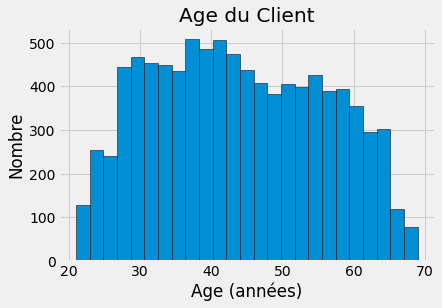

In [ ]:
# On définit le type de graphique
plt.style.use('fivethirtyeight')

# On représente la distribution de l'âge en années
plt.hist(train_corr['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age du Client'); plt.xlabel('Age (années)'); plt.ylabel('Nombre');

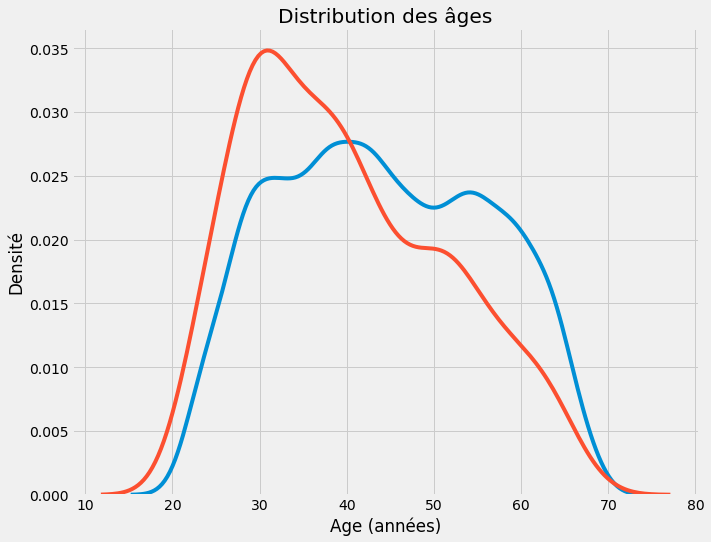

In [ ]:
# On définit les dimensions du graphique
plt.figure(figsize = (10, 8))

# KDE plot des prêts remboursés dans les temps
sns.kdeplot(train_corr.loc[train_corr['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'Prêt remboursé')

# KDE plot des prêts non remboursés dans les temps
sns.kdeplot(train_corr.loc[train_corr['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'En défaut')

# Légende
plt.xlabel('Age (années)')
plt.ylabel('Densité')
plt.title('Distribution des âges')
plt.show()

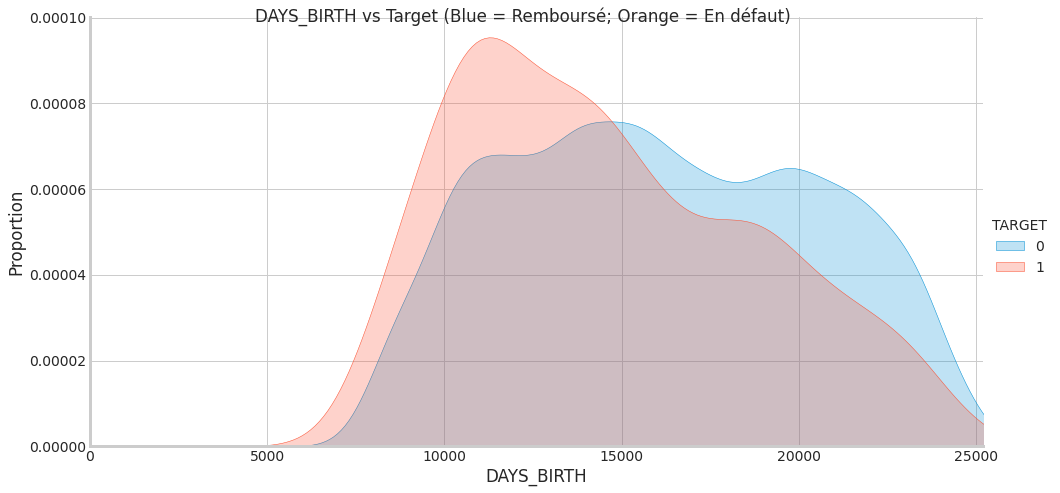

In [ ]:
sns.set_style("whitegrid")
age_plt = sns.FacetGrid(train_corr, hue="TARGET", height=7, aspect=2)
age_plt.map(sns.kdeplot,'DAYS_BIRTH',shade=True)
age_plt.set(xlim=(0, train_corr['DAYS_BIRTH'].max()))
age_plt.add_legend()
age_plt.set_axis_labels('DAYS_BIRTH', 'Proportion')
age_plt.fig.suptitle('DAYS_BIRTH vs Target (Blue = Remboursé; Orange = En défaut)')
plt.show()

In [ ]:
# On crée un nouveau dataframe contenant la target et les informations de l'âge uniquement
age_data = train_corr[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# On regroupe l'âge en classes de 5 ans
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       0     19066.0    52.235616  (50.0, 55.0]
1       0     16321.0    44.715068  (40.0, 45.0]
2       0      9511.0    26.057534  (25.0, 30.0]
3       0     17607.0    48.238356  (45.0, 50.0]
4       0     19823.0    54.309589  (50.0, 55.0]
5       0     13839.0    37.915068  (35.0, 40.0]
6       1     18202.0    49.868493  (45.0, 50.0]
7       0     20079.0    55.010959  (55.0, 60.0]
8       0     21440.0    58.739726  (55.0, 60.0]
9       0     22755.0    62.342466  (60.0, 65.0]

In [ ]:
# On regroupe par classe, et on calcule les moyennes
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.131980   8546.307107    23.414540
(25.0, 30.0]  0.113797  10178.957704    27.887555
(30.0, 35.0]  0.104096  11855.154437    32.479875
(35.0, 40.0]  0.088025  13718.946075    37.586154
(40.0, 45.0]  0.070120  15511.176096    42.496373
(45.0, 50.0]  0.059223  17327.006796    47.471251
(50.0, 55.0]  0.066482  19189.734995    52.574616
(55.0, 60.0]  0.045593  20979.005066    57.476726
(60.0, 65.0]  0.050360  22777.478417    62.404050
(65.0, 70.0]  0.023148  24315.685185    66.618316

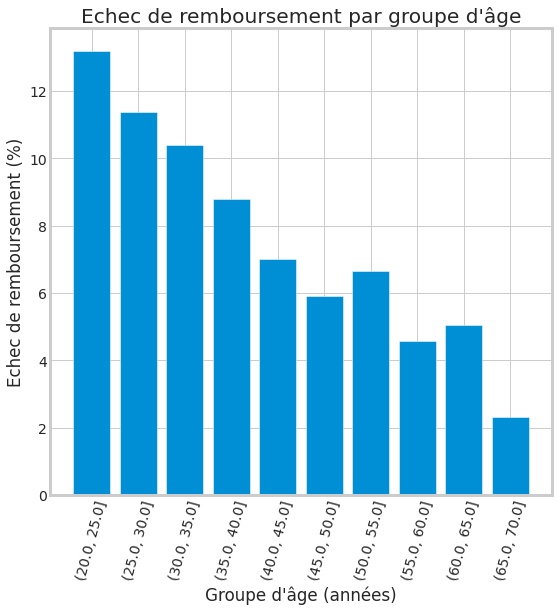

In [ ]:
# On définit les dimensions du graphique
plt.figure(figsize = (8, 8))

# On représente les classes d'âge et la moyenne de la target en bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Légende
plt.xticks(rotation = 75); plt.xlabel('Groupe d\'âge (années)'); plt.ylabel('Echec de remboursement (%)')
plt.title('Echec de remboursement par groupe d\'âge');

### Sources extérieures
- Ce sont les 3 variables qui ont les plus fortes corrélations négatives avec la target

In [ ]:
# Extraction des variables EXT_SOURCE et affichage des corrélations
ext_data = train_na[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.162748     -0.150437     -0.181400    0.093818
EXT_SOURCE_1 -0.162748      1.000000      0.230244      0.261396   -0.733352
EXT_SOURCE_2 -0.150437      0.230244      1.000000      0.140236   -0.101408
EXT_SOURCE_3 -0.181400      0.261396      0.140236      1.000000   -0.227214
DAYS_BIRTH    0.093818     -0.733352     -0.101408     -0.227214    1.000000

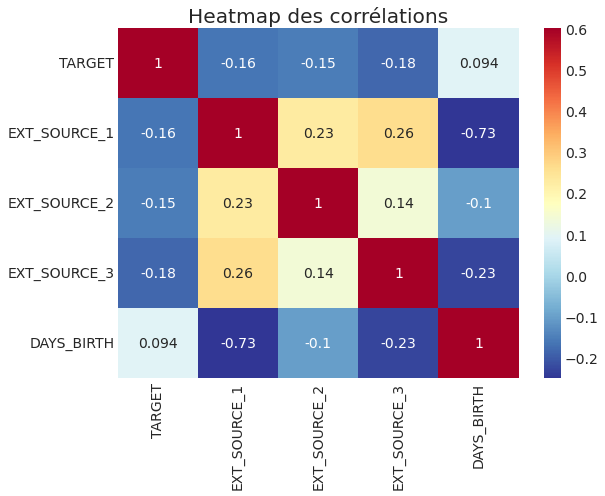

In [ ]:
# On définit les dimensions du graphique
plt.figure(figsize = (8, 6))

# On affiche la heatmap des corrélations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations');

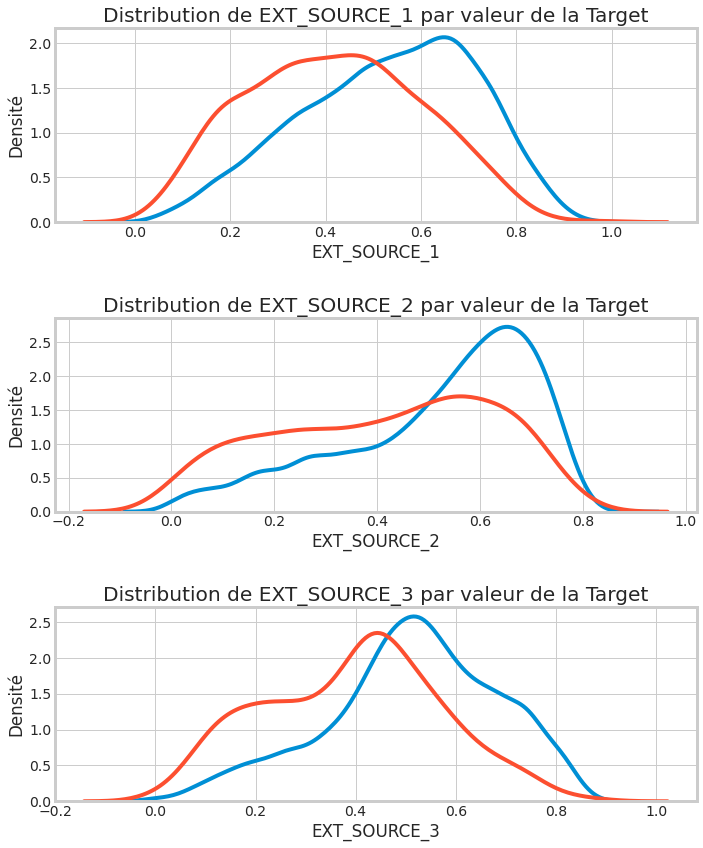

In [ ]:
# On définit les dimensions du graphique
plt.figure(figsize = (10, 12))

# On itère sur les trois sources:
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # On crée un subplot pour chaque source
    plt.subplot(3, 1, i + 1)
    # On affiche le subplot des prêts remboursés
    sns.kdeplot(train_na.loc[train_na['TARGET'] == 0, source], label = 'target == 0')
    # Puis on affiche le subplot des prêts non remboursés
    sns.kdeplot(train_na.loc[train_na['TARGET'] == 1, source], label = 'target == 1')
    
    # Légende
    plt.title('Distribution de %s par valeur de la Target' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densité');
    
plt.tight_layout(h_pad = 2.5)

# Domain Knowledge Features

In [ ]:
# Je crée de nouvelles colonnes dans le jeu d'entraînement:
train_na['CREDIT_INCOME_PERCENT'] = train_na['AMT_CREDIT'] / train_na['AMT_INCOME_TOTAL']
train_na['ANNUITY_INCOME_PERCENT'] = train_na['AMT_ANNUITY'] / train_na['AMT_INCOME_TOTAL']
train_na['CREDIT_TERM'] = train_na['AMT_ANNUITY'] / train_na['AMT_CREDIT']
train_na['DAYS_EMPLOYED_PERCENT'] = train_na['DAYS_EMPLOYED'] / train_na['DAYS_BIRTH']

In [ ]:
# Je crée les mêmes colonnes dans le jeu de test:
test_na['CREDIT_INCOME_PERCENT'] = test_na['AMT_CREDIT'] / test_na['AMT_INCOME_TOTAL']
test_na['ANNUITY_INCOME_PERCENT'] = test_na['AMT_ANNUITY'] / test_na['AMT_INCOME_TOTAL']
test_na['CREDIT_TERM'] = test_na['AMT_ANNUITY'] / test_na['AMT_CREDIT']
test_na['DAYS_EMPLOYED_PERCENT'] = test_na['DAYS_EMPLOYED'] / test_na['DAYS_BIRTH']

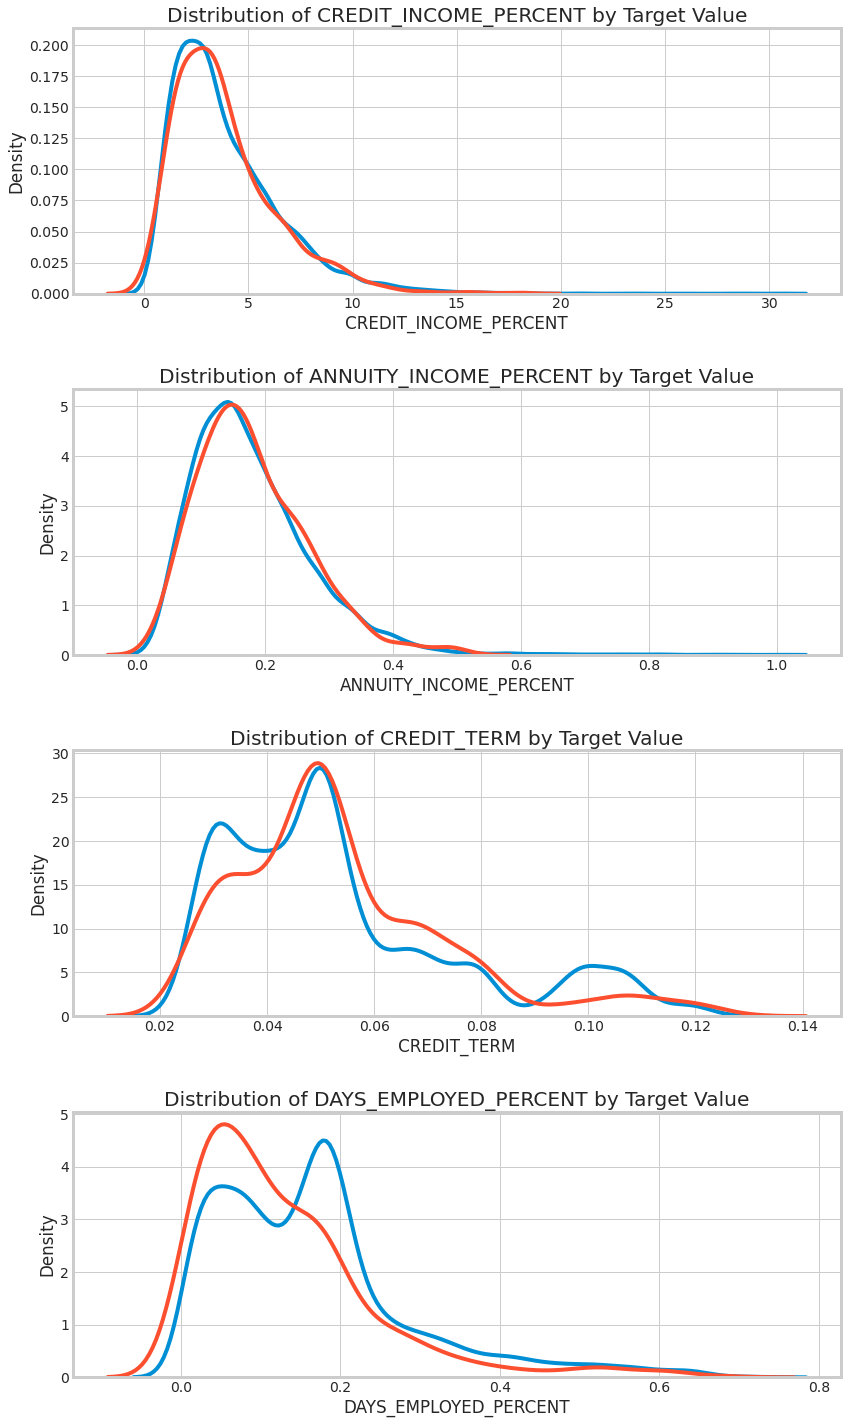

In [ ]:
# Visualisation de ces nouvelles variables dans un KDE plot, coloré par la target:

# Dimensions du graphique:
plt.figure(figsize = (12, 20))

# On itère sur ces features:
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):    
    # Création d'un subplot pour chaque source:
    plt.subplot(4, 1, i + 1)
    # Plot pour les prêts remboursés:
    sns.kdeplot(train_na.loc[train_na['TARGET'] == 0, feature], label = 'target == 0')
    # Plot pour les prêts non remboursés:
    sns.kdeplot(train_na.loc[train_na['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# Normalisation des données

In [ ]:
# Pour la normalisation
from sklearn.preprocessing import MinMaxScaler

# J'initie le scaler
scaler = MinMaxScaler()

In [ ]:
# Je duplique mes jeux de données, en supprimant la colonne identifiant
train_norm = train_na.drop(columns='SK_ID_CURR')
test_norm = test_na.drop(columns='SK_ID_CURR')

In [ ]:
# Je supprime la colonne cible avant normalisation
train_norm = train_norm.drop(columns=['TARGET'])

In [ ]:
# Je fit sur le jeu de données d'entrainement
scaler.fit(train_norm)

MinMaxScaler()

In [ ]:
# Puis je transforme les données d'entrainement et de test
train_norm[:] = scaler.transform(train_norm)
test_norm[:] = scaler.transform(test_norm)

In [ ]:
# J'ajoute de nouveau la target
train_norm['TARGET'] = train_na['TARGET']

In [ ]:
# J'ajoute de nouveaux les identifiants
train_norm['SK_ID_CURR'] = train_na['SK_ID_CURR']
test_norm['SK_ID_CURR'] = test_na['SK_ID_CURR']

In [ ]:
# Je vérifie leur structure
print('Training data shape: ', train_norm.shape)
print('Test data shape :', test_norm.shape)

Training data shape:  (9225, 233)
Test data shape : (1462, 232)


In [ ]:
# J'exporte mes données pour ne pas avoir à les regénérer à ce point
train_norm.to_csv("P7_train_norm.csv", sep='\t', index=False)
test_norm.to_csv("P7_test_norm.csv", sep='\t', index=False)

# Feature selection
- A verifier, ne fonctionne pas bien
- Cf: https://scikit-learn.org/stable/modules/permutation_importance.html
- Cf: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

In [ ]:
# Dézipper le fichier
!unzip P7_norm_data.zip

Archive:  P7_norm_data.zip
  inflating: P7_norm_data/P7_test_norm.csv  
  inflating: P7_norm_data/P7_train_norm.csv  


In [ ]:
# Lecture des jeux de données
train_norm = pd.read_csv('P7_norm_data/P7_train_norm.csv', sep='\t')
test_norm = pd.read_csv('P7_norm_data/P7_test_norm.csv', sep='\t')

In [ ]:
# Je commence par définir mes features et ma target
X = train_norm[train_norm.columns[:-1]]
y = train_norm.TARGET

AttributeError: ignored

In [ ]:
# Import de la librairie
from sklearn.model_selection import learning_curve, StratifiedKFold, train_test_split

# Je split mes données
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=23)

In [ ]:
# Réutilisation de fonctions, à personnaliser !

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: 'Remboursé', 1: 'En défaut'}

In [ ]:
# Trop long (stoppé à 53 minutes)

# Import des librairies
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
Y_train=np.asarray(Y_train)
Y_test=np.asarray(Y_test)

# BEGIN: FEATURE SELECTION WITH PERMUTATION IMPORTANCE METHOD
#http://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html
sel = SelectFromModel(PermutationImportance(RandomForestClassifier(), cv=5),threshold=0.005,).fit(X_train, Y_train)
X_train2 = sel.transform(X_train)
X_test2 = sel.transform(X_test)
# END: FEATURE SELECTION WITH PERMUTATION IMPORTANCE METHOD

KeyboardInterrupt: ignored

In [ ]:
# Non utilisé, à tester

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTressClassifier()

model.fit(X, y)

# Représentation
feat_importance = pd.Series(model.feature_importances_, index=X.columns)
# Pour avoir les 5 plus grosses (chiffre à modifier)
feat_importance.nlargest(5).plot(kind='barh')
plt.show()

# Visualisation t-SNE

In [ ]:
# Dézipper le fichier
!unzip P7_norm_data.zip

Archive:  P7_norm_data.zip
  inflating: P7_norm_data/P7_test_norm.csv  
  inflating: P7_norm_data/P7_train_norm.csv  


In [ ]:
# Lecture des jeux de données
train_norm = pd.read_csv('P7_norm_data/P7_train_norm.csv', sep='\t')
test_norm = pd.read_csv('P7_norm_data/P7_test_norm.csv', sep='\t')

In [ ]:
# Je duplique mes jeux de données, en supprimant la colonne identifiant
train_tsne = train_norm.drop(columns='SK_ID_CURR')
test_tsne = test_norm.drop(columns='SK_ID_CURR')

In [ ]:
# Je commence par définir mes features et ma target
X = train_tsne[train_tsne.columns[:-1]]
y = train_tsne.TARGET

In [ ]:
# Temps d'exécution:55 minutes

time_init = time.time()

# Réalisation du t-SNE
from sklearn.manifold import TSNE

embeddings = TSNE(n_components=2, perplexity=50, n_iter=1000, init='pca', random_state=23)

tsne_res = embeddings.fit_transform(X)

# Je stocke ces résultats
data_tsne = pd.DataFrame(tsne_res[:,0:2], columns=['tsne1', 'tsne2'])

# Ajout des labels
data_tsne['TARGET'] = train_norm['TARGET']

# On affiche la dimension de ce dataset
print(data_tsne.shape)

# Affichage du temps d'exécution
elapsed = time.time() - time_init
print('Temps de création du t-SNE: ', '%15.2f' % elapsed, 'secondes')

(61501, 3)
Temps de création du t-SNE:          3485.38 secondes


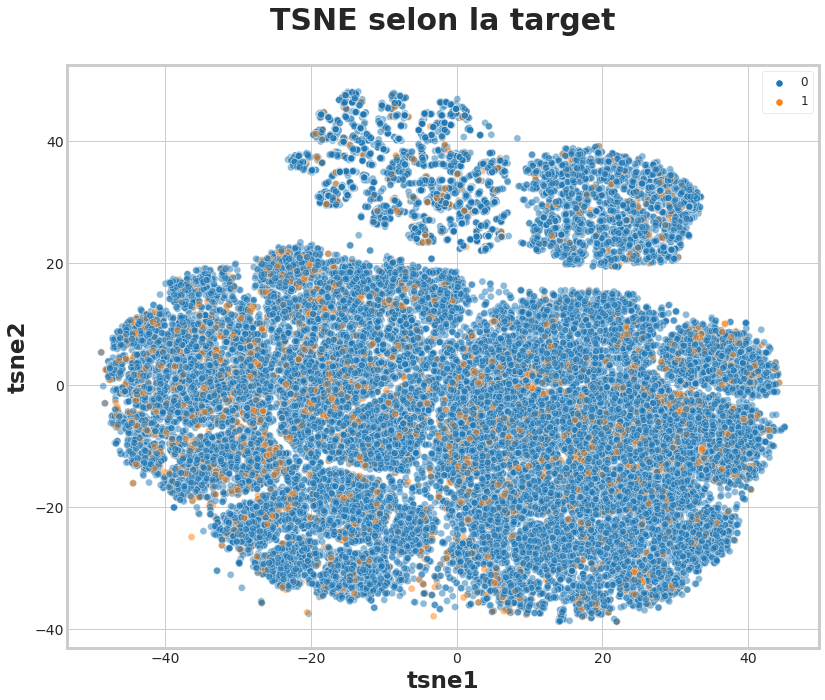

In [ ]:
# Définition des dimensions de la figure
plt.figure(figsize=(12, 10))

# Création du nuage de points, colorisé par class
sns.scatterplot(x='tsne1', y='tsne2', hue='TARGET', data=data_tsne, legend='brief', palette=sns.color_palette('tab10', n_colors=2), s=50, alpha=0.5)

# Ajout de la légende
plt.title('TSNE selon la target', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=23, fontweight='bold')
plt.ylabel('tsne2', fontsize=23, fontweight='bold')
plt.legend(prop={'size': 12})
plt.show()

# Modélisation
- Cf: https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a

In [ ]:
# Dézipper le fichier
#!unzip P7_norm_data.zip

Archive:  P7_norm_data.zip
  inflating: P7_norm_data/P7_test_norm.csv  
  inflating: P7_norm_data/P7_train_norm.csv  


In [ ]:
# Lecture des jeux de données
#train_norm = pd.read_csv('P7_norm_data/P7_train_norm.csv', sep='\t')
#test_norm = pd.read_csv('P7_norm_data/P7_test_norm.csv', sep='\t')

In [ ]:
# Lecture des jeux de données
train_norm = pd.read_csv('P7_train_norm.csv', sep='\t')
test_norm = pd.read_csv('P7_test_norm.csv', sep='\t')

In [ ]:
# Je duplique mes jeux de données, en supprimant la colonne identifiant
train_mdl = train_norm.drop(columns='SK_ID_CURR')
test_mdl = test_norm.drop(columns='SK_ID_CURR')

In [ ]:
# Je commence par définir mes features et ma target
X = train_mdl[train_mdl.columns[:-1]]
y = train_mdl.TARGET

In [ ]:
# Import de la librairie
from sklearn.model_selection import train_test_split

# Je split mes données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

## Sur les données non retouchées (avec le problème de class imbalance)
- Choix du score à optimiser: https://scikit-learn.org/stable/modules/model_evaluation.html

### Dummy Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Temps de traitement:             0.01 secondes

 F2-score (Class 0):  0.9853930865708167
 F2-score (Class 1):  0.0
 F2-score (Global):  0.9173981156405328

 Results:  (0.8667556185054629, 0.9309971098265896, 0.8977285508037872, None)

Classification Report

               precision    recall  f1-score   support

           0     0.9310    1.0000    0.9643      2577
           1     0.0000    0.0000    0.0000       191

    accuracy                         0.9310      2768
   macro avg     0.4655    0.5000    0.4821      2768
weighted avg     0.8668    0.9310    0.8977      2768


Confusion Matrix:


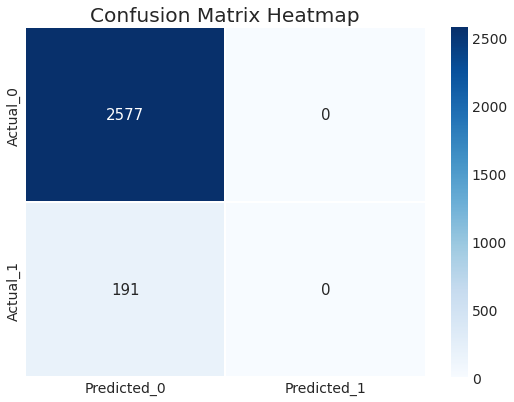

In [ ]:
time_init = time.time()

# Définition et entrainement du classifieur
from sklearn.dummy import DummyClassifier
classifier = DummyClassifier(random_state=23)
classifier.fit(X_train, y_train)

# Prédiction
y_pred = classifier.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred, digits=4)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score (Class 0): ', fbeta_score(y_test, y_pred, beta=2, pos_label=0, average='binary'))
print(' F2-score (Class 1): ', fbeta_score(y_test, y_pred, beta=2, pos_label=1, average='binary'))
print(' F2-score (Global): ', fbeta_score(y_test, y_pred, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred, beta=1, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print("\nConfusion Matrix:")
print('======================================================')
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (8,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', linewidth=1, annot_kws={'size':15})
# Liste de cmap: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.show()

### Régression logistique

In [ ]:
# Je vais chercher les meilleurs hyperparamètres pour le modèle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Je commence par fixer les valeurs des hyperparamètres à tester
param_grid = {'C':np.logspace(-5, 2, num=8), 'class_weight':[None, 'balanced']}

# Choix du score à optimiser
score = 'recall'

# Création d'un régresseur ridge avec recherche d'hyperparamètre par validation croisée
lr_c = GridSearchCV(LogisticRegression(random_state=23),
                    param_grid,
                    scoring=score,
                    n_jobs=-1,
                    cv=5,
                    verbose=5
)

# Optimisation de ce régresseur sur le jeu d'entraînement
lr_c.fit(X_train, y_train)

# Affichage des hyperparamètres optimaux
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(lr_c.best_params_)
# Affichage du meilleur score
print("Meilleur score sur le jeu d'entraînement:")
print(lr_c.best_score_)
# Affichage du meilleur modèle
print("Meilleur modèle sur le jeu d'entraînement:")
print(lr_c.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Meilleurs hyperparamètres sur le jeu d'entraînement:
{'C': 0.001, 'class_weight': 'balanced'}
Meilleur score sur le jeu d'entraînement:
0.6673076923076924
Meilleur modèle sur le jeu d'entraînement:
LogisticRegression(C=0.001, class_weight='balanced', random_state=23)


Temps de traitement:             0.02 secondes

 F2-score (Class 0):  0.6766447094138247
 F2-score (Class 1):  0.3492149431510558
 F2-score (Global):  0.6540511092128894

 Results:  (0.9049600171732705, 0.6329479768786127, 0.7230345777751247, None)

Classification Report

               precision    recall  f1-score   support

           0     0.9632    0.6298    0.7616      2577
           1     0.1191    0.6754    0.2025       191

    accuracy                         0.6329      2768
   macro avg     0.5412    0.6526    0.4821      2768
weighted avg     0.9050    0.6329    0.7230      2768


Confusion Matrix:


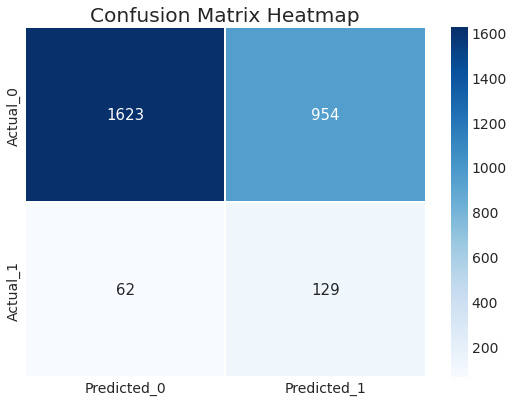

In [ ]:
time_init = time.time()

# Prédiction
y_pred = lr_c.best_estimator_.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred, digits=4)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score (Class 0): ', fbeta_score(y_test, y_pred, beta=2, pos_label=0, average='binary'))
print(' F2-score (Class 1): ', fbeta_score(y_test, y_pred, beta=2, pos_label=1, average='binary'))
print(' F2-score (Global): ', fbeta_score(y_test, y_pred, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred, beta=1, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print("\nConfusion Matrix:")
print('======================================================')
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (8,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', linewidth=1, annot_kws={'size':15})
# Liste de cmap: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.show()

### Balanced Random Forest
- A vérifier, ne fonctionne pas

In [ ]:
# Définition et entrainement du classifieur
#!pip install imbalanced-learn
#import imblearn
from imblearn.ensemble import BalancedRandomForestClassifier
classifier = BalancedRandomForestClassifier(max_depth=2, random_state=23)
classifier.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


ValueError: ignored

In [ ]:
time_init = time.time()

# Définition et entrainement du classifieur
#!pip install imbalanced-learn
#import imblearn
from imblearn.ensemble import BalancedRandomForestClassifier
classifier = BalancedRandomForestClassifier(random_state=23)
classifier.fit(X_train, y_train)

# Prédiction
y_pred = classifier.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score: ', fbeta_score(y_test, y_pred, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred, beta=2, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)

### Random Forest

In [ ]:
# Je vais chercher les meilleurs hyperparamètres pour le modèle
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Je commence par fixer les valeurs des hyperparamètres à tester
param_grid = {'class_weight':[None, 'balanced']}

# Choix du score à optimiser
score = 'recall'

# Création d'un régresseur ridge avec recherche d'hyperparamètre par validation croisée
rf_c = GridSearchCV(RandomForestClassifier(random_state=23),
                    param_grid,
                    scoring=score,
                    n_jobs=-1,
                    cv=5,
                    verbose=5
)

# Optimisation de ce régresseur sur le jeu d'entraînement
rf_c.fit(X_train, y_train)

# Affichage des hyperparamètres optimaux
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(rf_c.best_params_)
# Affichage du meilleur score
print("Meilleur score sur le jeu d'entraînement:")
print(rf_c.best_score_)
# Affichage du meilleur modèle
print("Meilleur modèle sur le jeu d'entraînement:")
print(rf_c.best_estimator_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs hyperparamètres sur le jeu d'entraînement:
{'class_weight': None}
Meilleur score sur le jeu d'entraînement:
0.0
Meilleur modèle sur le jeu d'entraînement:
RandomForestClassifier(random_state=23)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Temps de traitement:             0.08 secondes

 F2-score (Class 0):  0.9853930865708167
 F2-score (Class 1):  0.0
 F2-score (Global):  0.9173981156405328

 Results:  (0.8667556185054629, 0.9309971098265896, 0.8977285508037872, None)

Classification Report

               precision    recall  f1-score   support

           0     0.9310    1.0000    0.9643      2577
           1     0.0000    0.0000    0.0000       191

    accuracy                         0.9310      2768
   macro avg     0.4655    0.5000    0.4821      2768
weighted avg     0.8668    0.9310    0.8977      2768


Confusion Matrix:


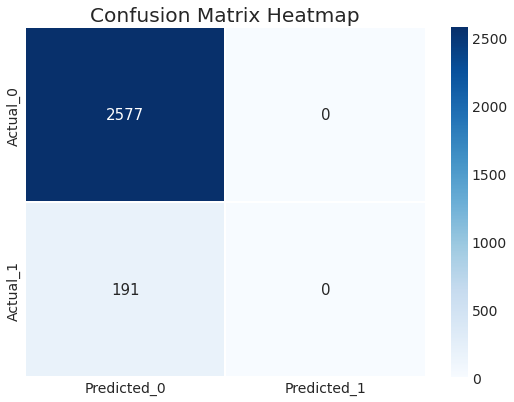

In [ ]:
time_init = time.time()

# Prédiction
y_pred = rf_c.best_estimator_.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred, digits=4)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score (Class 0): ', fbeta_score(y_test, y_pred, beta=2, pos_label=0, average='binary'))
print(' F2-score (Class 1): ', fbeta_score(y_test, y_pred, beta=2, pos_label=1, average='binary'))
print(' F2-score (Global): ', fbeta_score(y_test, y_pred, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred, beta=1, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print("\nConfusion Matrix:")
print('======================================================')
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (8,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', linewidth=1, annot_kws={'size':15})
# Liste de cmap: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.show()

### LightGBM

In [ ]:
# Je vais chercher les meilleurs hyperparamètres pour le modèle
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Je commence par fixer les valeurs des hyperparamètres à tester
param_grid = {'boosting_type':['gbdt', 'dart', 'goss', 'rf'], 'class_weight':[None, 'balanced']}

# Choix du score à optimiser
score = 'recall'

# Création d'un régresseur ridge avec recherche d'hyperparamètre par validation croisée
lgbm_c = GridSearchCV(LGBMClassifier(random_state=23),
                      param_grid,
                      scoring=score,
                      n_jobs=-1,
                      cv=5,
                      verbose=5
)

# Optimisation de ce régresseur sur le jeu d'entraînement
lgbm_c.fit(X_train, y_train)

# Affichage des hyperparamètres optimaux
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(lgbm_c.best_params_)
# Affichage du meilleur score
print("Meilleur score sur le jeu d'entraînement:")
print(lgbm_c.best_score_)
# Affichage du meilleur modèle
print("Meilleur modèle sur le jeu d'entraînement:")
print(lgbm_c.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 744, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 544, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    boost

Meilleurs hyperparamètres sur le jeu d'entraînement:
{'boosting_type': 'dart', 'class_weight': 'balanced'}
Meilleur score sur le jeu d'entraînement:
0.29615384615384616
Meilleur modèle sur le jeu d'entraînement:
LGBMClassifier(boosting_type='dart', class_weight='balanced', random_state=23)


Temps de traitement:             0.04 secondes

 F2-score (Class 0):  0.909340443886754
 F2-score (Class 1):  0.3076216712580349
 F2-score (Global):  0.867820109503775

 Results:  (0.8979674534022216, 0.8619942196531792, 0.8780716650358732, None)

Classification Report

               precision    recall  f1-score   support

           0     0.9492    0.8999    0.9239      2577
           1     0.2062    0.3508    0.2597       191

    accuracy                         0.8620      2768
   macro avg     0.5777    0.6253    0.5918      2768
weighted avg     0.8980    0.8620    0.8781      2768


Confusion Matrix:


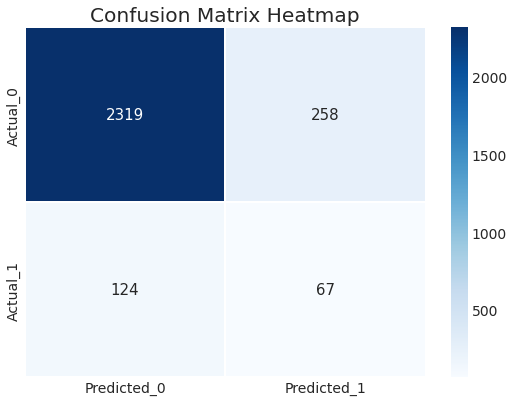

In [ ]:
time_init = time.time()

# Prédiction
y_pred = lgbm_c.best_estimator_.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred, digits=4)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score (Class 0): ', fbeta_score(y_test, y_pred, beta=2, pos_label=0, average='binary'))
print(' F2-score (Class 1): ', fbeta_score(y_test, y_pred, beta=2, pos_label=1, average='binary'))
print(' F2-score (Global): ', fbeta_score(y_test, y_pred, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred, beta=1, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print("\nConfusion Matrix:")
print('======================================================')
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (8,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', linewidth=1, annot_kws={'size':15})
# Liste de cmap: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.show()

## Sur les données corrigées avec SMOTE
- Cf: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
# Import de la librairie
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Définition d'une pipeline
over = SMOTE(sampling_strategy=0.1, random_state=23)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=23)
steps = [('o', over), ('u', under)]
pipeline_smote = Pipeline(steps=steps)

# On transforme le dataset
X_smote, y_smote = pipeline_smote.fit_resample(X, y)

In [ ]:
# Je split mes données
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smote, y_smote, test_size=0.3, random_state=23)

### Dummy Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Temps de traitement:             0.01 secondes

 F2-score (Class 0):  0.9853930865708167
 F2-score (Class 1):  0.0
 F2-score (Global):  0.9173981156405328

 Results:  (0.8667556185054629, 0.9309971098265896, 0.8977285508037872, None)

Classification Report

               precision    recall  f1-score   support

           0     0.9310    1.0000    0.9643      2577
           1     0.0000    0.0000    0.0000       191

    accuracy                         0.9310      2768
   macro avg     0.4655    0.5000    0.4821      2768
weighted avg     0.8668    0.9310    0.8977      2768


Confusion Matrix:


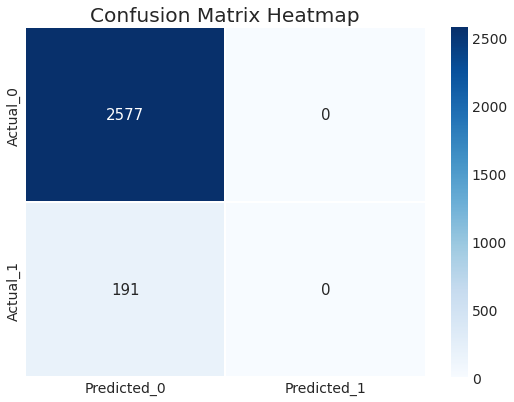

In [ ]:
time_init = time.time()

# Définition et entrainement du classifieur
from sklearn.dummy import DummyClassifier
classifier = DummyClassifier(random_state=23)
classifier.fit(X_train_s, y_train_s)

# Prédiction
y_pred_s = classifier.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred_s, digits=4)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score (Class 0): ', fbeta_score(y_test, y_pred_s, beta=2, pos_label=0, average='binary'))
print(' F2-score (Class 1): ', fbeta_score(y_test, y_pred_s, beta=2, pos_label=1, average='binary'))
print(' F2-score (Global): ', fbeta_score(y_test, y_pred_s, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred_s, beta=1, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print("\nConfusion Matrix:")
print('======================================================')
conf_mat = confusion_matrix(y_test, y_pred_s)
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (8,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', linewidth=1, annot_kws={'size':15})
# Liste de cmap: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.show()

### Régression logistique

In [ ]:
# Je vais chercher les meilleurs hyperparamètres pour le modèle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Je commence par fixer les valeurs des hyperparamètres à tester
param_grid = {'C':np.logspace(-5, 2, num=8), 'class_weight':[None, 'balanced']}

# Choix du score à optimiser
score = 'recall'

# Création d'un régresseur ridge avec recherche d'hyperparamètre par validation croisée
lr_c_s = GridSearchCV(LogisticRegression(random_state=23),
                      param_grid,
                      scoring=score,
                      n_jobs=-1,
                      cv=5,
                      verbose=5
)

# Optimisation de ce régresseur sur le jeu d'entraînement
lr_c_s.fit(X_train_s, y_train_s)

# Affichage des hyperparamètres optimaux
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(lr_c_s.best_params_)
# Affichage du meilleur score
print("Meilleur score sur le jeu d'entraînement:")
print(lr_c_s.best_score_)
# Affichage du meilleur modèle
print("Meilleur modèle sur le jeu d'entraînement:")
print(lr_c_s.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Meilleurs hyperparamètres sur le jeu d'entraînement:
{'C': 0.01, 'class_weight': 'balanced'}
Meilleur score sur le jeu d'entraînement:
0.6876575401999131
Meilleur modèle sur le jeu d'entraînement:
LogisticRegression(C=0.01, class_weight='balanced', random_state=23)


Temps de traitement:             0.02 secondes

 F2-score (Class 0):  0.6914185930483951
 F2-score (Class 1):  0.37486218302094815
 F2-score (Global):  0.6695752858535822

 Results:  (0.910129713735205, 0.6499277456647399, 0.7360776783593317, None)

Classification Report

               precision    recall  f1-score   support

           0     0.9680    0.6453    0.7744      2577
           1     0.1295    0.7120    0.2192       191

    accuracy                         0.6499      2768
   macro avg     0.5488    0.6787    0.4968      2768
weighted avg     0.9101    0.6499    0.7361      2768


Confusion Matrix:


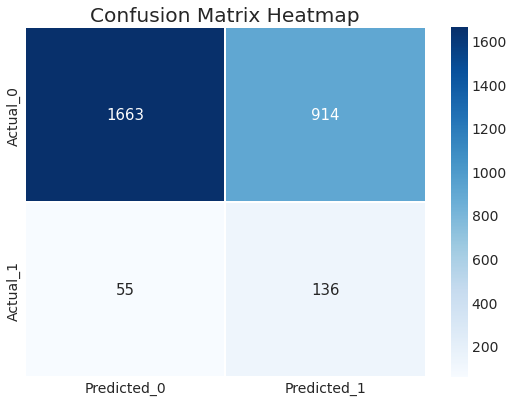

In [ ]:
time_init = time.time()

# Prédiction
y_pred_s = lr_c_s.best_estimator_.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred_s, digits=4)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score (Class 0): ', fbeta_score(y_test, y_pred_s, beta=2, pos_label=0, average='binary'))
print(' F2-score (Class 1): ', fbeta_score(y_test, y_pred_s, beta=2, pos_label=1, average='binary'))
print(' F2-score (Global): ', fbeta_score(y_test, y_pred_s, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred_s, beta=1, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print("\nConfusion Matrix:")
print('======================================================')
conf_mat = confusion_matrix(y_test, y_pred_s)
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (8,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', linewidth=1, annot_kws={'size':15})
# Liste de cmap: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.show()

### Random Forest

In [ ]:
# Je vais chercher les meilleurs hyperparamètres pour le modèle
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Je commence par fixer les valeurs des hyperparamètres à tester
param_grid = {'class_weight':[None, 'balanced']}

# Choix du score à optimiser
score = 'recall'

# Création d'un régresseur ridge avec recherche d'hyperparamètre par validation croisée
rf_c_s = GridSearchCV(RandomForestClassifier(random_state=23),
                      param_grid,
                      scoring=score,
                      n_jobs=-1,
                      cv=5,
                      verbose=5
)

# Optimisation de ce régresseur sur le jeu d'entraînement
rf_c_s.fit(X_train_s, y_train_s)

# Affichage des hyperparamètres optimaux
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(rf_c_s.best_params_)
# Affichage du meilleur score
print("Meilleur score sur le jeu d'entraînement:")
print(rf_c_s.best_score_)
# Affichage du meilleur modèle
print("Meilleur modèle sur le jeu d'entraînement:")
print(rf_c_s.best_estimator_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs hyperparamètres sur le jeu d'entraînement:
{'class_weight': None}
Meilleur score sur le jeu d'entraînement:
0.3379689989859481
Meilleur modèle sur le jeu d'entraînement:
RandomForestClassifier(random_state=23)


Temps de traitement:             0.07 secondes

 F2-score (Class 0):  0.95368486934752
 F2-score (Class 1):  0.7325141776937618
 F2-score (Global):  0.9384234524017584

 Results:  (0.9538289347986708, 0.9367774566473989, 0.9428461611590382, None)

Classification Report

               precision    recall  f1-score   support

           0     0.9854    0.9461    0.9654      2577
           1     0.5272    0.8115    0.6392       191

    accuracy                         0.9368      2768
   macro avg     0.7563    0.8788    0.8023      2768
weighted avg     0.9538    0.9368    0.9428      2768


Confusion Matrix:


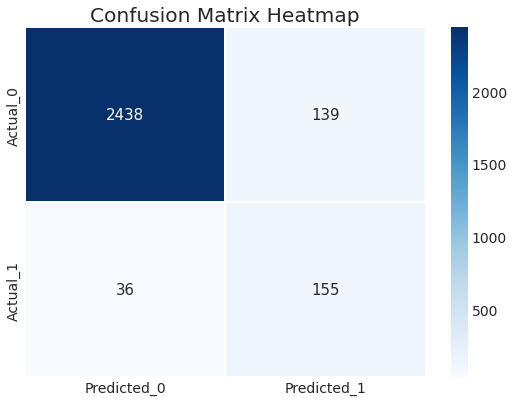

In [ ]:
time_init = time.time()

# Prédiction
y_pred_s = rf_c_s.best_estimator_.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred_s, digits=4)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score (Class 0): ', fbeta_score(y_test, y_pred_s, beta=2, pos_label=0, average='binary'))
print(' F2-score (Class 1): ', fbeta_score(y_test, y_pred_s, beta=2, pos_label=1, average='binary'))
print(' F2-score (Global): ', fbeta_score(y_test, y_pred_s, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred_s, beta=1, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print("\nConfusion Matrix:")
print('======================================================')
conf_mat = confusion_matrix(y_test, y_pred_s)
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (8,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', linewidth=1, annot_kws={'size':15})
# Liste de cmap: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.show()

### LightGBM

In [ ]:
# Je vais chercher les meilleurs hyperparamètres pour le modèle
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Je commence par fixer les valeurs des hyperparamètres à tester
param_grid = {'boosting_type':['gbdt', 'dart', 'goss', 'rf'], 'class_weight':[None, 'balanced']}

# Choix du score à optimiser
score = 'recall'

# Création d'un régresseur ridge avec recherche d'hyperparamètre par validation croisée
lgbm_c_s = GridSearchCV(LGBMClassifier(random_state=23),
                        param_grid,
                        scoring=score,
                        n_jobs=-1,
                        cv=5,
                        verbose=5
)

# Optimisation de ce régresseur sur le jeu d'entraînement
lgbm_c_s.fit(X_train_s, y_train_s)

# Affichage des hyperparamètres optimaux
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(lgbm_c_s.best_params_)
# Affichage du meilleur score
print("Meilleur score sur le jeu d'entraînement:")
print(lgbm_c_s.best_score_)
# Affichage du meilleur modèle
print("Meilleur modèle sur le jeu d'entraînement:")
print(lgbm_c_s.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 744, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 544, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    boost

Meilleurs hyperparamètres sur le jeu d'entraînement:
{'boosting_type': 'goss', 'class_weight': 'balanced'}
Meilleur score sur le jeu d'entraînement:
0.5942343908445603
Meilleur modèle sur le jeu d'entraînement:
LGBMClassifier(boosting_type='goss', class_weight='balanced', random_state=23)


Temps de traitement:             0.03 secondes

 F2-score (Class 0):  0.8391749254693418
 F2-score (Class 1):  0.5983205038488453
 F2-score (Global):  0.8225552742664823

 Results:  (0.9398867195736657, 0.8143063583815029, 0.8563154842789249, None)

Classification Report

               precision    recall  f1-score   support

           0     0.9905    0.8083    0.8902      2577
           1     0.2571    0.8953    0.3995       191

    accuracy                         0.8143      2768
   macro avg     0.6238    0.8518    0.6449      2768
weighted avg     0.9399    0.8143    0.8563      2768


Confusion Matrix:


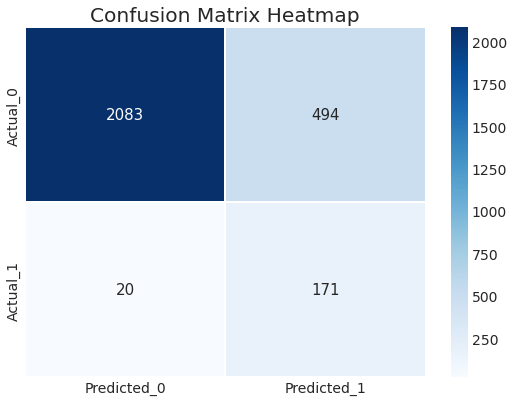

In [ ]:
time_init = time.time()

# Prédiction
y_pred_s = lgbm_c_s.best_estimator_.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred_s, digits=4)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score (Class 0): ', fbeta_score(y_test, y_pred_s, beta=2, pos_label=0, average='binary'))
print(' F2-score (Class 1): ', fbeta_score(y_test, y_pred_s, beta=2, pos_label=1, average='binary'))
print(' F2-score (Global): ', fbeta_score(y_test, y_pred_s, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred_s, beta=1, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print("\nConfusion Matrix:")
print('======================================================')
conf_mat = confusion_matrix(y_test, y_pred_s)
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (8,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', linewidth=1, annot_kws={'size':15})
# Liste de cmap: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.show()

## Sur les données corrigées avec SMOTETomek

In [ ]:
# Import de la librairie
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Définition d'une pipeline
over_t = SMOTETomek(sampling_strategy=0.1, random_state=23)
under_t = RandomUnderSampler(sampling_strategy=0.5, random_state=23)
steps_t = [('o', over_t), ('u', under_t)]
pipeline_smt = Pipeline(steps=steps_t)

# On transforme le dataset
X_smt, y_smt = pipeline_smt.fit_resample(X, y)

In [ ]:
# Je split mes données
X_train_smt, X_test_smt, y_train_smt, y_test_smt = train_test_split(X_smt, y_smt, test_size=0.3, random_state=23)

### Dummy Classifier

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Temps de traitement:             0.01 secondes

 F2-score (Class 0):  0.9853930865708167
 F2-score (Class 1):  0.0
 F2-score (Global):  0.9173981156405328

 Results:  (0.8667556185054629, 0.9309971098265896, 0.8977285508037872, None)

Classification Report

               precision    recall  f1-score   support

           0     0.9310    1.0000    0.9643      2577
           1     0.0000    0.0000    0.0000       191

    accuracy                         0.9310      2768
   macro avg     0.4655    0.5000    0.4821      2768
weighted avg     0.8668    0.9310    0.8977      2768


Confusion Matrix:


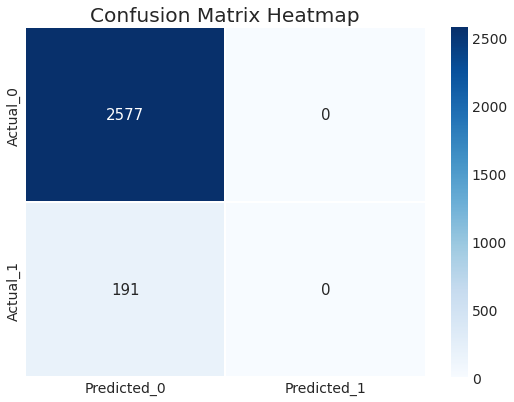

In [ ]:
time_init = time.time()

# Définition et entrainement du classifieur
from sklearn.dummy import DummyClassifier
classifier = DummyClassifier(random_state=23)
classifier.fit(X_train_smt, y_train_smt)

# Prédiction
y_pred_smt = classifier.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred_smt, digits=4)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score (Class 0): ', fbeta_score(y_test, y_pred_smt, beta=2, pos_label=0, average='binary'))
print(' F2-score (Class 1): ', fbeta_score(y_test, y_pred_smt, beta=2, pos_label=1, average='binary'))
print(' F2-score (Global): ', fbeta_score(y_test, y_pred_smt, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred_smt, beta=1, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print("\nConfusion Matrix:")
print('======================================================')
conf_mat = confusion_matrix(y_test, y_pred_smt)
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (8,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', linewidth=1, annot_kws={'size':15})
# Liste de cmap: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.show()

### Régression logistique

In [ ]:
# Je vais chercher les meilleurs hyperparamètres pour le modèle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Je commence par fixer les valeurs des hyperparamètres à tester
param_grid = {'C':np.logspace(-5, 2, num=8), 'class_weight':[None, 'balanced']}

# Choix du score à optimiser
score = 'recall'

# Création d'un régresseur ridge avec recherche d'hyperparamètre par validation croisée
lr_c_smt = GridSearchCV(LogisticRegression(random_state=23),
                        param_grid,
                        scoring=score,
                        n_jobs=-1,
                        cv=5,
                        verbose=5
)

# Optimisation de ce régresseur sur le jeu d'entraînement
lr_c_smt.fit(X_train_smt, y_train_smt)

# Affichage des hyperparamètres optimaux
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(lr_c_smt.best_params_)
# Affichage du meilleur score
print("Meilleur score sur le jeu d'entraînement:")
print(lr_c_smt.best_score_)
# Affichage du meilleur modèle
print("Meilleur modèle sur le jeu d'entraînement:")
print(lr_c_smt.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Meilleurs hyperparamètres sur le jeu d'entraînement:
{'C': 1e-05, 'class_weight': 'balanced'}
Meilleur score sur le jeu d'entraînement:
0.748
Meilleur modèle sur le jeu d'entraînement:
LogisticRegression(C=1e-05, class_weight='balanced', random_state=23)


Temps de traitement:             0.02 secondes

 F2-score (Class 0):  0.5828927170390584
 F2-score (Class 1):  0.3311258278145695
 F2-score (Global):  0.5655200740325999

 Results:  (0.9046685838618321, 0.544436416184971, 0.649670779320309, None)

Classification Report

               precision    recall  f1-score   support

           0     0.9640    0.5305    0.6844      2577
           1     0.1037    0.7330    0.1817       191

    accuracy                         0.5444      2768
   macro avg     0.5339    0.6317    0.4330      2768
weighted avg     0.9047    0.5444    0.6497      2768


Confusion Matrix:


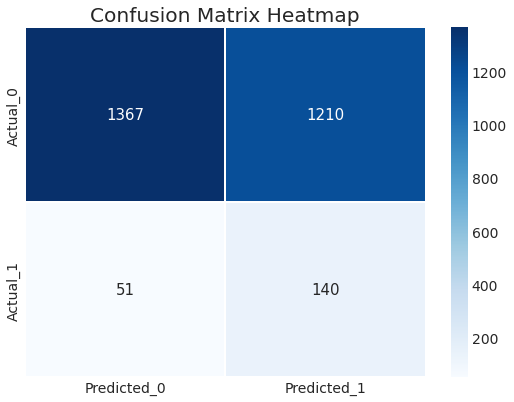

In [ ]:
time_init = time.time()

# Prédiction
y_pred_smt = lr_c_smt.best_estimator_.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred_smt, digits=4)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score (Class 0): ', fbeta_score(y_test, y_pred_smt, beta=2, pos_label=0, average='binary'))
print(' F2-score (Class 1): ', fbeta_score(y_test, y_pred_smt, beta=2, pos_label=1, average='binary'))
print(' F2-score (Global): ', fbeta_score(y_test, y_pred_smt, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred_smt, beta=1, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print("\nConfusion Matrix:")
print('======================================================')
conf_mat = confusion_matrix(y_test, y_pred_smt)
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (8,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', linewidth=1, annot_kws={'size':15})
# Liste de cmap: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.show()

### Random Forest

In [ ]:
# Je vais chercher les meilleurs hyperparamètres pour le modèle
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Je commence par fixer les valeurs des hyperparamètres à tester
param_grid = {'class_weight':[None, 'balanced']}

# Choix du score à optimiser
score = 'recall'

# Création d'un régresseur ridge avec recherche d'hyperparamètre par validation croisée
rf_c_smt = GridSearchCV(RandomForestClassifier(random_state=23),
                        param_grid,
                        scoring=score,
                        n_jobs=-1,
                        cv=5,
                        verbose=5
)

# Optimisation de ce régresseur sur le jeu d'entraînement
rf_c_smt.fit(X_train_smt, y_train_smt)

# Affichage des hyperparamètres optimaux
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(rf_c_smt.best_params_)
# Affichage du meilleur score
print("Meilleur score sur le jeu d'entraînement:")
print(rf_c_smt.best_score_)
# Affichage du meilleur modèle
print("Meilleur modèle sur le jeu d'entraînement:")
print(rf_c_smt.best_estimator_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs hyperparamètres sur le jeu d'entraînement:
{'class_weight': None}
Meilleur score sur le jeu d'entraînement:
0.36
Meilleur modèle sur le jeu d'entraînement:
RandomForestClassifier(random_state=23)


Temps de traitement:             0.07 secondes

 F2-score (Class 0):  0.9589575530586766
 F2-score (Class 1):  0.6884765624999999
 F2-score (Global):  0.940293582973161

 Results:  (0.9498573595175741, 0.9389450867052023, 0.943201347632271, None)

Classification Report

               precision    recall  f1-score   support

           0     0.9801    0.9538    0.9668      2577
           1     0.5423    0.7382    0.6253       191

    accuracy                         0.9389      2768
   macro avg     0.7612    0.8460    0.7960      2768
weighted avg     0.9499    0.9389    0.9432      2768


Confusion Matrix:


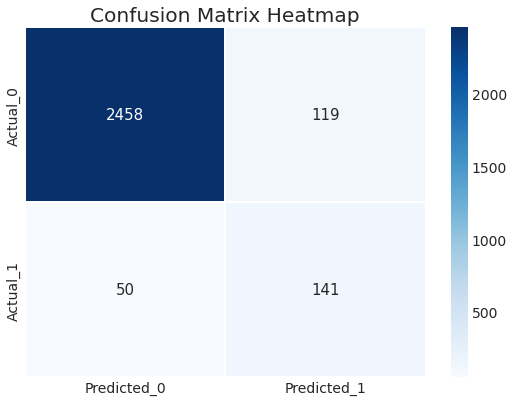

In [ ]:
time_init = time.time()

# Prédiction
y_pred_smt = rf_c_smt.best_estimator_.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred_smt, digits=4)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score (Class 0): ', fbeta_score(y_test, y_pred_smt, beta=2, pos_label=0, average='binary'))
print(' F2-score (Class 1): ', fbeta_score(y_test, y_pred_smt, beta=2, pos_label=1, average='binary'))
print(' F2-score (Global): ', fbeta_score(y_test, y_pred_smt, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred_smt, beta=1, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print("\nConfusion Matrix:")
print('======================================================')
conf_mat = confusion_matrix(y_test, y_pred_smt)
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (8,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', linewidth=1, annot_kws={'size':15})
# Liste de cmap: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.show()

### LightGBM

In [ ]:
# Je vais chercher les meilleurs hyperparamètres pour le modèle
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Je commence par fixer les valeurs des hyperparamètres à tester
param_grid = {'boosting_type':['gbdt', 'dart', 'goss', 'rf'], 'class_weight':[None, 'balanced']}

# Choix du score à optimiser
score = 'recall'

# Création d'un régresseur ridge avec recherche d'hyperparamètre par validation croisée
lgbm_c_smt = GridSearchCV(LGBMClassifier(random_state=23),
                          param_grid,
                          scoring=score,
                          n_jobs=-1,
                          cv=5,
                          verbose=5
)

# Optimisation de ce régresseur sur le jeu d'entraînement
lgbm_c_smt.fit(X_train_smt, y_train_smt)

# Affichage des hyperparamètres optimaux
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(lgbm_c_smt.best_params_)
# Affichage du meilleur score
print("Meilleur score sur le jeu d'entraînement:")
print(lgbm_c_smt.best_score_)
# Affichage du meilleur modèle
print("Meilleur modèle sur le jeu d'entraînement:")
print(lgbm_c_smt.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 744, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 544, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    boost

Meilleurs hyperparamètres sur le jeu d'entraînement:
{'boosting_type': 'goss', 'class_weight': 'balanced'}
Meilleur score sur le jeu d'entraînement:
0.6079999999999999
Meilleur modèle sur le jeu d'entraînement:
LGBMClassifier(boosting_type='goss', class_weight='balanced', random_state=23)


Temps de traitement:             0.04 secondes

 F2-score (Class 0):  0.8402381143914408
 F2-score (Class 1):  0.5571327182398865
 F2-score (Global):  0.8207030238332952

 Results:  (0.9328831754775022, 0.8114161849710982, 0.8535143587745878, None)

Classification Report

               precision    recall  f1-score   support

           0     0.9840    0.8106    0.8889      2577
           1     0.2434    0.8220    0.3756       191

    accuracy                         0.8114      2768
   macro avg     0.6137    0.8163    0.6323      2768
weighted avg     0.9329    0.8114    0.8535      2768


Confusion Matrix:


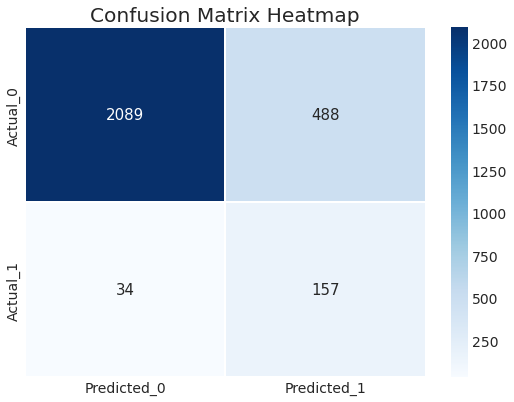

In [ ]:
time_init = time.time()

# Prédiction
y_pred_smt = lgbm_c_smt.best_estimator_.predict(X_test)

# Classification metrics
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, classification_report, confusion_matrix
classification_report = classification_report(y_test, y_pred_smt, digits=4)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

print('\n F2-score (Class 0): ', fbeta_score(y_test, y_pred_smt, beta=2, pos_label=0, average='binary'))
print(' F2-score (Class 1): ', fbeta_score(y_test, y_pred_smt, beta=2, pos_label=1, average='binary'))
print(' F2-score (Global): ', fbeta_score(y_test, y_pred_smt, beta=2, average='weighted'))
print('\n Results: ', precision_recall_fscore_support(y_test, y_pred_smt, beta=1, average='weighted'))
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)
print("\nConfusion Matrix:")
print('======================================================')
conf_mat = confusion_matrix(y_test, y_pred_smt)
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (8,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', linewidth=1, annot_kws={'size':15})
# Liste de cmap: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.show()

# Création de la pipeline + sérialisation

## Création de fonctions

In [ ]:
# Permet de ne sélectionner qu'un pourcentage du jeu d'origine, si trop volumineux
# Par défaut, on sélectionne 10%
def subsample_percent_df(df, frac=.1):
  df = df.sample(frac=frac, random_state=23)
  # On réindexe ensuite
  df = df.reset_index(drop=True)

  return df

In [ ]:
# Permet de ne pas considérer le genre XNA, qui parait aberrant
def rm_gender_XNA(df):
  df = df[df['CODE_GENDER'] != 'XNA']
  # On réindexe ensuite
  df = df.reset_index(drop=True)

  return df

In [ ]:
# Fonction pour calculer les valeurs manquantes par colonne
def missing_values_table(df):
        # Valeurs manquantes total
        mis_val = df.isnull().sum()
        
        # Pourcentage de valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Création d'une table de résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # On renomme les colonnes
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Valeurs manquantes', 1 : '% du total'})
        
        # On trie la table par pourcentage de valeurs manquantes DESC
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% du total', ascending=False).round(1)
        
        # On affiche un résumé d'informations
        print ("Le dataframe sélectionné a " + str(df.shape[1]) + " colonnes.\nIl y a " + str(mis_val_table_ren_columns.shape[0]) + " colonnes qui ont des valeurs manquantes.")
        
        # On retourne le tableau des valeurs manquantes
        return mis_val_table_ren_columns

In [ ]:
# Fonction pour créer la colonne DAYS_EMPLOYED_ANOM
def create_days_emp_anom(df):
  # Création de la colonne flag:
  df['DAYS_EMPLOYED_ANOM'] = df['DAYS_EMPLOYED']==365243
  # On remplace les valeurs par np.nan
  df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

  return df

In [ ]:
# Fonction pour remplacer les valeurs manquantes par une autre valeur donnée
def fill_by_value(df_col, value_fill):
  df_col.fillna(value=value_fill, inplace=True)

  return df_col

## Création de la pipeline

In [ ]:
# Transformer les booléens (int64, object) en booléens (bool)
# - pour les dtypes 'object' avec deux valeurs uniquement => booléen
# - pour les dtypes 'int64' avec deux valeurs uniquement => booléen

# Anomalies:
# - création de la colonne 'DAYS_EMPLOYED_ANOM' (booléen) basée sur la colonne 'DAYS_EMPLOYED' dont la valeur est 365243

# Traitement des nan:
# - pour certains dtypes 'object': remplacer par 'Unknown' ou autre valeur (en fonction)
# - pour les dtypes 'object' avec 2 catégories: LabelEncoder
# - pour les autres 'object': pd.get_dummies, + alignement sur les données test
# - pour les colonnes quanti restantes: IterativeImputer

# Création de nouvelles features:
# - 'CREDIT_INCOME_PERCENT' = 'AMT_CREDIT' / 'AMT_INCOME_TOTAL'
# - 'ANNUITY_INCOME_PERCENT' = 'AMT_ANNUITY' / 'AMT_INCOME_TOTAL'
# - 'CREDIT_TERM' = 'AMT_ANNUITY' / 'AMT_CREDIT'
# - 'DAYS_EMPLOYED_PERCENT' = 'DAYS_EMPLOYED' / 'DAYS_BIRTH'

# Normalisation:
# - avec MinMaxScaler ici

# Modélisation:
# - Meilleur modèle: SMOTE + RandomUnderSampler
# - Puis, RandomForestClassifier(class_weight=None, random_state=23)



# Déployer le best_estimator avec ML_flow

## Sérialisation
- Cf: https://medium.com/thecyphy/home-credit-default-risk-part-3-5ab7b35ccdd4

### Export du modèle

In [ ]:
# On commence par redéfinir le meilleur modèle
from sklearn.ensemble import RandomForestClassifier

best_mdl = RandomForestClassifier(random_state=23)
best_mdl.fit(X_train_s, y_train_s)

RandomForestClassifier(random_state=23)

In [ ]:
import joblib

In [ ]:
#joblib.dump(rf_c_s.best_estimator_, 'final_model.pkl')
joblib.dump(best_mdl, 'best_model.pkl')

['best_model.pkl']

In [ ]:
saved_mdl = joblib.load('best_model.pkl')

# Test LIME
- Cf: https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html

In [ ]:
pip install lime

     |████████████████████████████████| 275 kB 5.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=148023db4eea3e738cf1f97f64eb49b485c3d48eea3c2c0d41e2d3626c46e9c4
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

In [ ]:
# Copie des jeux de données
lime_train = train_norm.copy()
lime_test = test_norm.copy()

In [ ]:
X_train

NAME_CONTRACT_TYPE  CODE_GENDER  ...  CREDIT_TERM  DAYS_EMPLOYED_PERCENT
32844                 0.0          1.0  ...     0.042950               0.389217
37704                 0.0          0.0  ...     0.763110               0.435682
7401                  0.0          0.0  ...     0.053012               0.047325
12721                 0.0          0.0  ...     0.042791               0.026631
45730                 0.0          0.0  ...     0.070011               0.150435
...                   ...          ...  ...          ...                    ...
9704                  1.0          1.0  ...     0.272848               0.147672
11190                 0.0          1.0  ...     0.442401               0.210486
26569                 0.0          1.0  ...     0.445959               0.052475
9256                  0.0          0.0  ...     0.314370               0.172522
41555                 0.0          1.0  ...     0.366059               0.146400

[43050 rows x 242 columns]

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=list(train_mdl.columns), class_names=['TARGET'], mode='classification')

In [ ]:
X_test.keys

<bound method NDFrame.keys of        NAME_CONTRACT_TYPE  CODE_GENDER  ...  CREDIT_TERM  DAYS_EMPLOYED_PERCENT
20635                 0.0          0.0  ...     0.283152               0.530049
18910                 1.0          0.0  ...     0.272848               0.246920
46297                 0.0          1.0  ...     0.070962               0.299995
17527                 0.0          0.0  ...     0.108322               0.391469
6244                  0.0          0.0  ...     0.285440               0.241278
...                   ...          ...  ...          ...                    ...
53582                 0.0          0.0  ...     0.070011               0.787333
48039                 0.0          0.0  ...     0.198290               0.197491
26941                 0.0          1.0  ...     0.540342               0.594543
60871                 1.0          0.0  ...     0.272848               0.063569
28485                 0.0          0.0  ...     0.069988               0.144371

[18451 ro

In [ ]:
exp = explainer.explain_instance(X_test.loc[20635], rf_c_s.predict_proba, num_features=2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
exp.show_in_notebook()

# Test SHAP
- Cf: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [ ]:
pip install shap

     |████████████████████████████████| 564 kB 13.8 MB/s 


In [ ]:
import shap

In [ ]:
time_init = time.time()

explainer = shap.TreeExplainer(best_mdl)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

Temps de traitement:             0.02 secondes


In [ ]:
X_train

NAME_CONTRACT_TYPE  CODE_GENDER  ...  CREDIT_TERM  DAYS_EMPLOYED_PERCENT
5317                 1.0          0.0  ...     0.271542               0.370695
6790                 0.0          1.0  ...     0.315314               0.217075
3664                 0.0          0.0  ...     0.040347               0.065214
74                   0.0          0.0  ...     0.501913               0.048465
3030                 0.0          1.0  ...     0.099446               0.101913
...                  ...          ...  ...          ...                    ...
3674                 0.0          0.0  ...     0.692767               0.019030
39                   0.0          1.0  ...     0.253011               0.341708
347                  0.0          1.0  ...     0.889130               0.156191
6175                 0.0          1.0  ...     0.069343               0.198586
8787                 0.0          1.0  ...     0.841012               0.034897

[6457 rows x 231 columns]

In [ ]:
X_train.iloc[[1]]

NAME_CONTRACT_TYPE  CODE_GENDER  ...  CREDIT_TERM  DAYS_EMPLOYED_PERCENT
6790                 0.0          1.0  ...     0.315314               0.217075

[1 rows x 231 columns]

## SHAP Values

In [ ]:
val_test = X_train.iloc[[1]]

In [ ]:
time_init = time.time()

shap_values = explainer.shap_values(val_test)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

Temps de traitement:             0.02 secondes


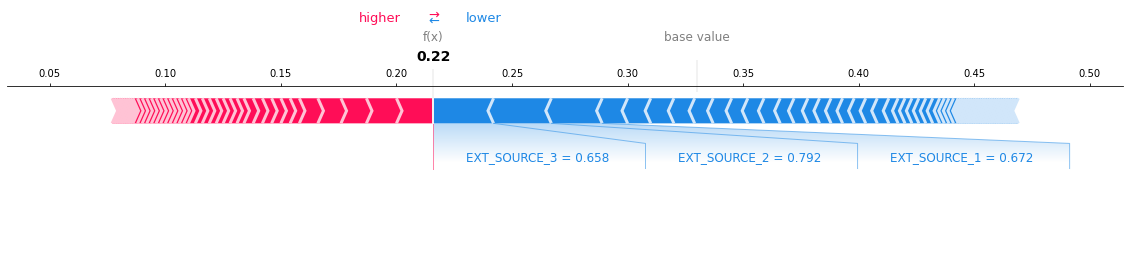

In [ ]:
time_init = time.time()

shap.force_plot(np.round(explainer.expected_value[1],3),
                np.round(shap_values[1],3),
                np.round(val_test,3),
                matplotlib=True,
                show=False)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

## Feature importance SHAP

In [ ]:
feat_imp_array = val_test.values.reshape(1, -1)

In [ ]:
time_init = time.time()

best_mdl.predict_proba(feat_imp_array)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

Temps de traitement:             0.02 secondes


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [ ]:
feat_imp = pd.Series(best_mdl.feature_importances_, index=X_train.columns)

In [ ]:
feat_imp.nlargest(10)

EXT_SOURCE_3                    0.047800
EXT_SOURCE_2                    0.039007
EXT_SOURCE_1                    0.030779
DAYS_ID_PUBLISH                 0.019710
DAYS_EMPLOYED                   0.018704
DAYS_BIRTH                      0.018304
DAYS_EMPLOYED_PERCENT           0.016787
OWN_CAR_AGE                     0.015693
YEARS_BEGINEXPLUATATION_MEDI    0.015237
DAYS_REGISTRATION               0.014216
dtype: float64

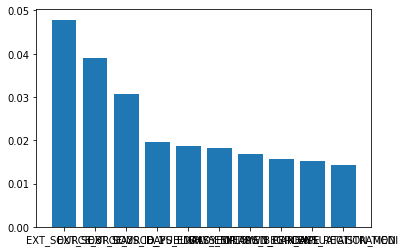

In [ ]:
plt.bar(feat_imp.nlargest(10).index, feat_imp.nlargest(10).values)
plt.show()

In [ ]:
import plotly.express as px

In [ ]:
px.bar(feat_imp.nlargest(10), feat_imp.nlargest(10).index, feat_imp.nlargest(10).values)

## SHAP beeswarm

In [ ]:
time_init = time.time()

shap_val_full = explainer(X_train)

elapsed = time.time() - time_init
print('Temps de traitement: ', '%15.2f' % elapsed, 'secondes')

Temps de traitement:           129.68 secondes


In [ ]:
# Ne fonctionne pas, cf contournement ci-dessous
#shap.plots.beeswarm(shap_val_full)

ValueError: ignored

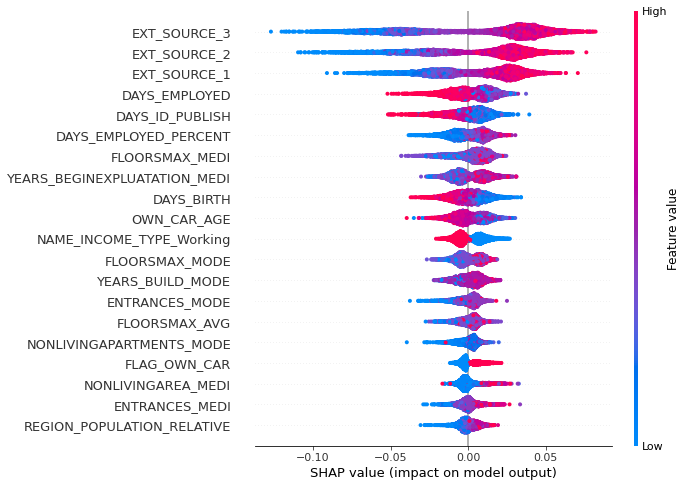

In [ ]:
shap.summary_plot(shap_values=np.take(shap_val_full.values, 0, axis=-1),
                  features=X_train,
                  feature_names=X_train.columns,
                  plot_size=(8,8),
                  sort=True,
                  show=False)
plt.show()

## SHAP summary plot

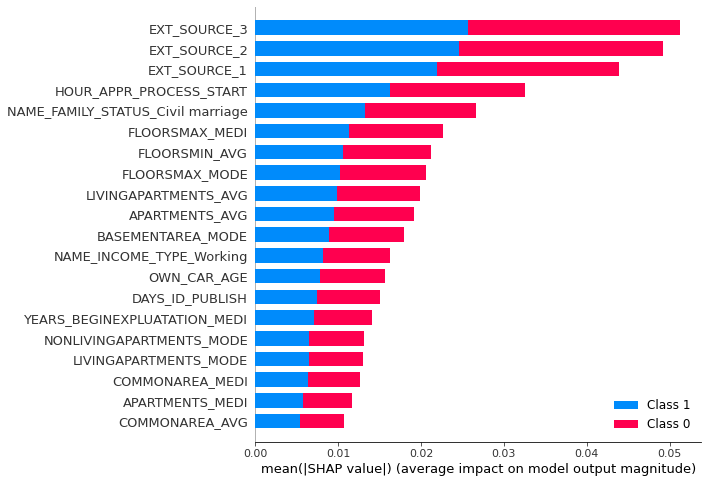

In [ ]:
shap.summary_plot(shap_values=shap_values,
                  features=val_test,
                  feature_names=val_test.columns,
                  plot_size=(8,8),
                  sort=True,
                  show=False)
plt.show()